# 문제1 CIFAR-10을 활용한 이미지 분류

## 설정

필요한 라이브러리 불러오기

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from PIL import Image
from google.colab import drive


drive.mount('/content/Mydrive')

Mounted at /content/Mydrive


In [ ]:
from pathlib import Path

save_dir = Path('/content/Mydrive/MyDrive/object detection datasets/CIFAR10/Model')

In [ ]:
import os
import json

def save_history_to_json(history, directory, filename="history.json"):
    """
    모델 학습 히스토리를 JSON 파일로 저장하는 함수.

    Parameters:
    - history (keras.callbacks.History): model.fit()으로 반환된 학습 히스토리 객체.
    - directory (str): 히스토리를 저장할 디렉토리 경로.
    - filename (str): 저장할 파일 이름. 기본값은 'history.json'.

    Returns:
    - None
    """
    try:
        # 디렉토리가 존재하지 않으면 생성
        if not os.path.exists(directory):
            os.makedirs(directory)

        # 저장 경로 설정
        file_path = os.path.join(directory, filename)

        # 히스토리 객체에서 딕셔너리 추출
        history_dict = history.history

        # JSON 파일로 저장
        with open(file_path, 'w') as json_file:
            json.dump(history_dict, json_file)

        print(f"History successfully saved to {file_path}")
    except Exception as e:
        print(f"An error occurred while saving history: {e}")


[CIFAR-10 데이터셋에 대한 설명](https://www.cs.toronto.edu/~kriz/cifar.html)

기본적인 머신러닝 워크플로우를 따른다.
1. 데이터 검사 및 이해하기
2. 입력 파이프라인 빌드하기
3. 모델 빌드하기
4. 모델 훈련하기
5. 모델 테스트하기
6. 모델을 개선하고 프로세스 반복하기


## 데이터 불러오기

In [ ]:
from keras.datasets import cifar10
# 데이터 불러오기
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 데이터 확인
print(f"x_train shape: {x_train.shape}" )
print(f"y_train shape: {y_train.shape}" )
print(f"x_test shape: {x_test.shape}" )
print(f"y_test shape: {y_test.shape}" )

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


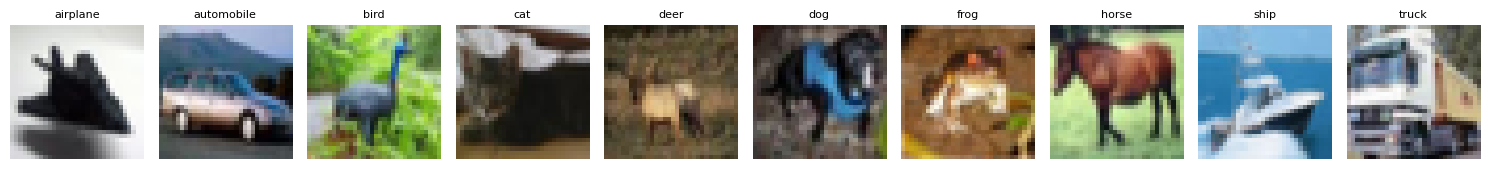

In [ ]:
# 각 클래스의 첫이미지 확인

class_names = [
    "airplane", "automobile", "bird", "cat",
    "deer", "dog", "frog", "horse",
    "ship", "truck"
]

# 각 클래스의 첫 번째 이미지 선택
num_classes = 10
class_images = []
for class_idx in range(num_classes):
    # 해당 클래스에 속하는 첫 번째 이미지 검색
    idx = np.where(y_train.flatten() == class_idx)[0][0]
    class_images.append((x_train[idx], class_names[class_idx]))

# 시각화
fig, axes = plt.subplots(1, num_classes, figsize=(15, 5))  # 1행 10열 서브플롯 생성

for i, (img_array, class_name) in enumerate(class_images):
    img = Image.fromarray(img_array)  # NumPy 배열을 PIL 이미지로 변환
    axes[i].imshow(img)
    axes[i].axis("off")  # 축 숨김
    axes[i].set_title(class_name, fontsize=8)  # 클래스 이름 추가

plt.tight_layout()
plt.show()

CIFAR10 데이터 셋의 경우 8비트 컬러를 사용하기 때문에, 이미지를 한 개의 열로 만든 다음 255로 나눠 0과 1사이의 값으로 정규화를 거칠것이다.

### 시각화 함수

In [ ]:
def plot_accuracy_and_loss(history):
    """
    모델 학습 과정에서 정확도와 손실을 시각화하는 함수.

    Parameters:
        history: keras.callbacks.History - 모델 학습 후 반환된 히스토리 객체.

    Returns:
        None
    """
    import matplotlib.pyplot as plt

    # 에포크 수
    epochs = range(1, len(history.history['accuracy']) + 1)

    # 그래프 크기 설정
    plt.figure(figsize=(14, 6))

    # 1. 정확도 시각화
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', marker='o', linestyle='--')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)

    # 2. 손실 시각화
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss', marker='o')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', marker='o', linestyle='--')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)

    # 레이아웃 정리 및 출력
    plt.tight_layout()
    plt.show()


In [ ]:
def visualize_model_char(model, x_val, y_val, class_names=None):
    """
    모델의 성능을 평가하고 혼동 행렬과 다양한 지표를 시각화합니다.

    Parameters:
        model: keras.Model - 평가할 Keras 모델
        x_val: np.array - 검증 데이터 (입력)
        y_val: np.array 또는 list - 검증 데이터 (레이블)
        class_names: list - 클래스 이름 (옵션, 제공하지 않을 경우 숫자 인덱스로 표시)

    Returns:
        None
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import (precision_recall_curve, roc_curve,
                                 auc, classification_report,
                                 confusion_matrix, f1_score)
    from sklearn.preprocessing import label_binarize
    import numpy as np

    # y_val을 numpy 배열로 변환
    y_val = np.array(y_val)

    # 클래스 이름 설정
    num_classes = len(np.unique(y_val))
    if class_names is None:
        class_names = ["airplane", "automobile", "bird",
                       "cat","deer", "dog", "frog",
                       "horse","ship", "truck"]

    # 예측 수행
    predictions = model.predict(x_val)
    predicted_classes = predictions.argmax(axis=1)

    # 레이블 이진화 (ROC-AUC 및 다중 클래스 대응)
    y_val_binarized = label_binarize(y_val, classes=range(num_classes))

    # 정밀도-재현율 곡선 및 ROC 곡선 준비
    precision = {}
    recall = {}
    fpr = {}
    tpr = {}
    pr_auc = {}
    roc_auc = {}

    for i in range(num_classes):
        precision[i], recall[i], thresholds = precision_recall_curve(y_val_binarized[:, i], predictions[:, i])
        fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], predictions[:, i])
        pr_auc[i] = auc(recall[i], precision[i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 1. Precision-Recall Curve 서브플롯
    fig, axes = plt.subplots(2, 5, figsize=(18, 9))
    axes = axes.ravel()

    for i in range(num_classes):
        # F1-스코어 계산
        f1_scores = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i] + 1e-10)
        max_f1_index = np.argmax(f1_scores)
        max_f1 = f1_scores[max_f1_index]

        # PR 커브 그리기
        axes[i].plot(recall[i], precision[i], label=f'PR AUC = {pr_auc[i]:.2f}')
        axes[i].scatter(recall[i][max_f1_index], precision[i][max_f1_index], color='red', label=f'Max F1 = {max_f1:.2f}')
        axes[i].set_title(f'Precision-Recall: {class_names[i]}')
        axes[i].set_xlabel('Recall')
        axes[i].set_ylabel('Precision')
        axes[i].legend()
        axes[i].grid()

    plt.tight_layout()
    plt.show()

    # 2. ROC Curve 서브플롯
    fig, axes = plt.subplots(2, 5, figsize=(18, 9))
    axes = axes.ravel()

    for i in range(num_classes):
        axes[i].plot(fpr[i], tpr[i], label=f'ROC AUC = {roc_auc[i]:.2f}')
        axes[i].plot([0, 1], [0, 1], 'k--')  # Random Guess
        axes[i].set_title(f'ROC Curve: {class_names[i]}')
        axes[i].set_xlabel('False Positive Rate')
        axes[i].set_ylabel('True Positive Rate')
        axes[i].legend()
        axes[i].grid()

    plt.tight_layout()
    plt.show()

    # 3. 혼동 행렬 시각화
    conf_matrix = confusion_matrix(y_val, predicted_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # 4. Classification Report
    print("\nClassification Report:")
    print(classification_report(y_val, predicted_classes, target_names=class_names))

    # 5. F1-Score 막대그래프
    f1_per_class = f1_score(y_val, predicted_classes, average=None)

    plt.figure(figsize=(8, 6))
    plt.bar(range(num_classes), f1_per_class, tick_label=class_names)
    plt.title('F1-Score per Class')
    plt.xlabel('Class')
    plt.ylabel('F1-Score')
    plt.grid(axis='y')
    plt.show()


## 인공신경망

<img src='https://www.lgcns.com/wp-content/uploads/2021/11/240AB64358C78B0E22.png'>

[출처: LG CNS, 인공신경망이란 무엇인가?](https://www.lgcns.com/blog/cns-tech/ai-data/14558/)

위 그림은 인공신경망을 나타내는 그림이다. 출력층의 개수가 클래스의 개수이다. 이를 바탕으로 클래스를 예측하기 때문에 신경망의 최종 값을 만든다는 의미에서 **출력층**이라고 부른다.\
\
인공신경망에서는 $z$값을 계산하는 단위를 **뉴런**이라고 부른다. 하지만 뉴런에서 일어나는 일은 선형계산이 전부이다. 이제 뉴런이란 표헌 대신에 **유닛**이라고 부르는 사람이 더 많아지고 있다.\
\
그리고 **입력층**이 있다. 입력층은 특별한 계산을 수행하지 않는다. 위 예제에 대입해보면 픽셀값이 입력층인 것이다.\
\
로지스틱 회귀에서는 교차 검증을 사용해 모델을 평가했지만, 인공신경망에서는 교차 검증을 잘 사용하지 않고 검증 세트를 별도로 덜어내 사용한다고 한다. 그 이유는
1. 딥러닝 분야의 데이터셋은 충분히 크기 때문에 검증점수가 안정적이다.
2. 교차 검증을 수행하기에는 훈련 시간이 너무 오래 걸린다.\
\
이렇기 때문에 아래에는 `train_test_split`함수를 사용해 검증세트를 별도로 덜어내 사용하겠다.

In [ ]:
x_train = x_train.reshape(-1, 32*32*3)
train_scaled = x_train / 255.0

x_test = x_test.reshape(-1, 32*32*3)
test_scaled = x_test / 255.0

train_target = y_train.ravel()
test_target = y_test.ravel()



In [ ]:
from sklearn.model_selection import train_test_split

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

In [ ]:
print(f'train_scaled shape: {train_scaled.shape}')
print(f'train_target shape: {train_target.shape}')
print(f'val_scaled shape: {val_scaled.shape}')
print(f'val_target shape: {val_target.shape}')
print(f'test_scaled shape: {test_scaled.shape}')
print(f'test_target shape: {test_target.shape}')

train_scaled shape: (40000, 3072)
train_target shape: (40000,)
val_scaled shape: (10000, 3072)
val_target shape: (10000,)
test_scaled shape: (10000, 3072)
test_target shape: (10000,)


가장 기본이 되는 밀집층(Dense Layer)를 사용해 모델을 만들어보자.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Input

CIFAR10_1layer_NN = Sequential(
    [Input(shape=(train_scaled.shape[1:])),
    Dense(10, activation='softmax')],
    name='CIFAR10_1layer_NN')

CIFAR10_1layer_NN.summary()

Model: "CIFAR10_1layer_NN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │          30,730 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,730 (120.04 KB)

 Trainable params: 30,730 (120.04 KB)

 Non-trainable params: 0 (0.00 B)

`Sequential`클래스의 객채를 만들 때 앞에서 만든 밀집층의 객체 `dense`를 전달했다.

In [ ]:
CIFAR10_1layer_NN.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

손실함수로는 다중분류에서 사용하는 교차 엔트로피 `sparse_categorical_crossentropy`를 사용했다. 다중 분류에서 크로스 엔트로피 손실 함수를 적용하려면 0, 1, 2 같이 정수로 된 타깃값을 원-핫 인코딩으로 변환해야한다.


In [ ]:
print(train_target[:10])

[6 2 5 6 3 3 8 3 3 0]


하지만 CIFAR10 데이터 타깃값은 모두 정수로 되어있다. 하지만 텐서플로우에서는 정수로 된 타깃값을 원-핫 인코딩으로 바꾸지 않고 사용할 수 있다. 정수로된 타깃값을 사용해 크로스 엔트로피 손실을 계산하는 것이 바로 `sparse_catergorical_crossentropy`이다.

In [ ]:
one_layer_hist = CIFAR10_1layer_NN.fit(
    train_scaled, train_target,
    epochs=50,
    validation_data=(val_scaled, val_target),
    batch_size=32,
    verbose=0)

In [ ]:
CIFAR10_1layer_NN.save(save_dir / 'model1.keras')
save_history_to_json(one_layer_hist, save_dir, 'model1_history.json')

History successfully saved to /content/Mydrive/MyDrive/object detection datasets/CIFAR10/Model/model1_history.json


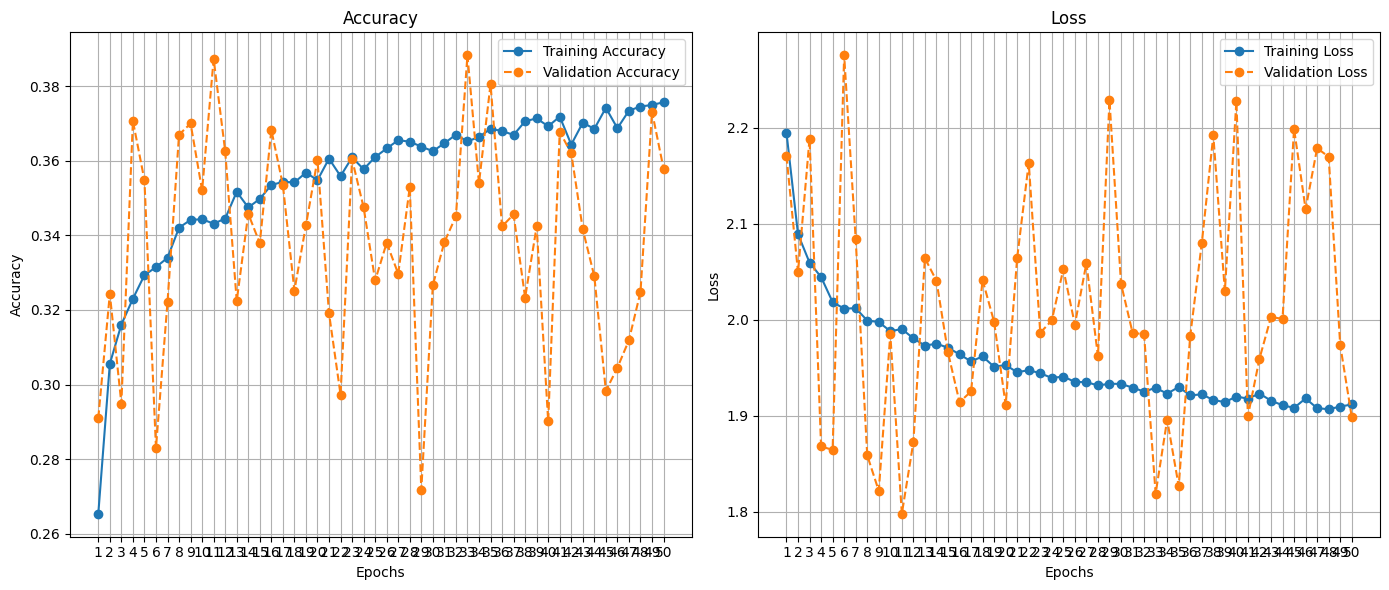

In [ ]:
plot_accuracy_and_loss(one_layer_hist)

아무래도 단층신경망을 사용하다보니 성능이 좋지 않다.
\
하지만 인공신경망의 원리를 사용해 신경망을 여러개 사용하는 심층 신경망으로 발전 시킬 목적이 생겼다.

## 심층 신경망

In [ ]:
dense1 = Dense(100, activation='sigmoid', name='Dense_1')
dense2 = Dense(10, activation='softmax', name='Dense_2')

CIFAR10_2layer_NN = Sequential(
    [Input(shape=(train_scaled.shape[1:])),
    dense1,
    dense2],
    name='CIFAR10_2layer_NN')

In [ ]:
CIFAR10_2layer_NN.summary()

Model: "CIFAR10_2layer_NN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Dense_1 (Dense)                      │ (None, 100)                 │         307,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 308,310 (1.18 MB)

 Trainable params: 308,310 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
CIFAR10_2layer_NN.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
two_layer_hist = CIFAR10_2layer_NN.fit(
    train_scaled, train_target,
    epochs=50,
    validation_data=(val_scaled, val_target),
    batch_size=32,
    verbose=0)

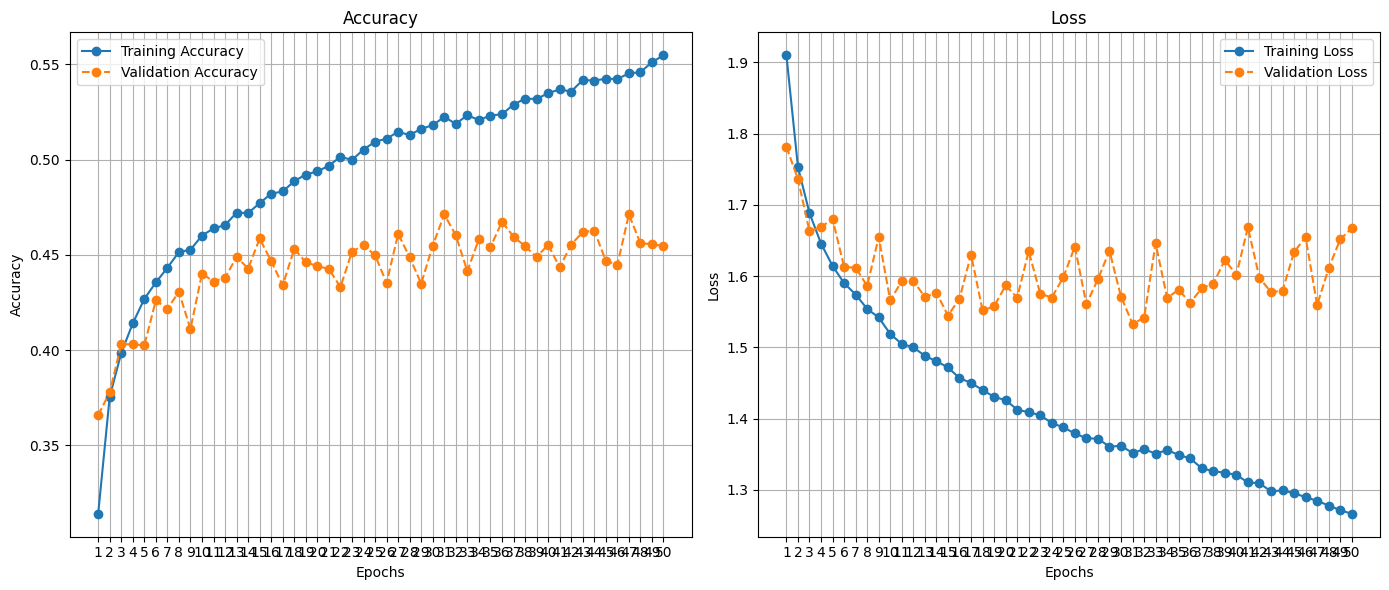

In [ ]:
plot_accuracy_and_loss(two_layer_hist)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


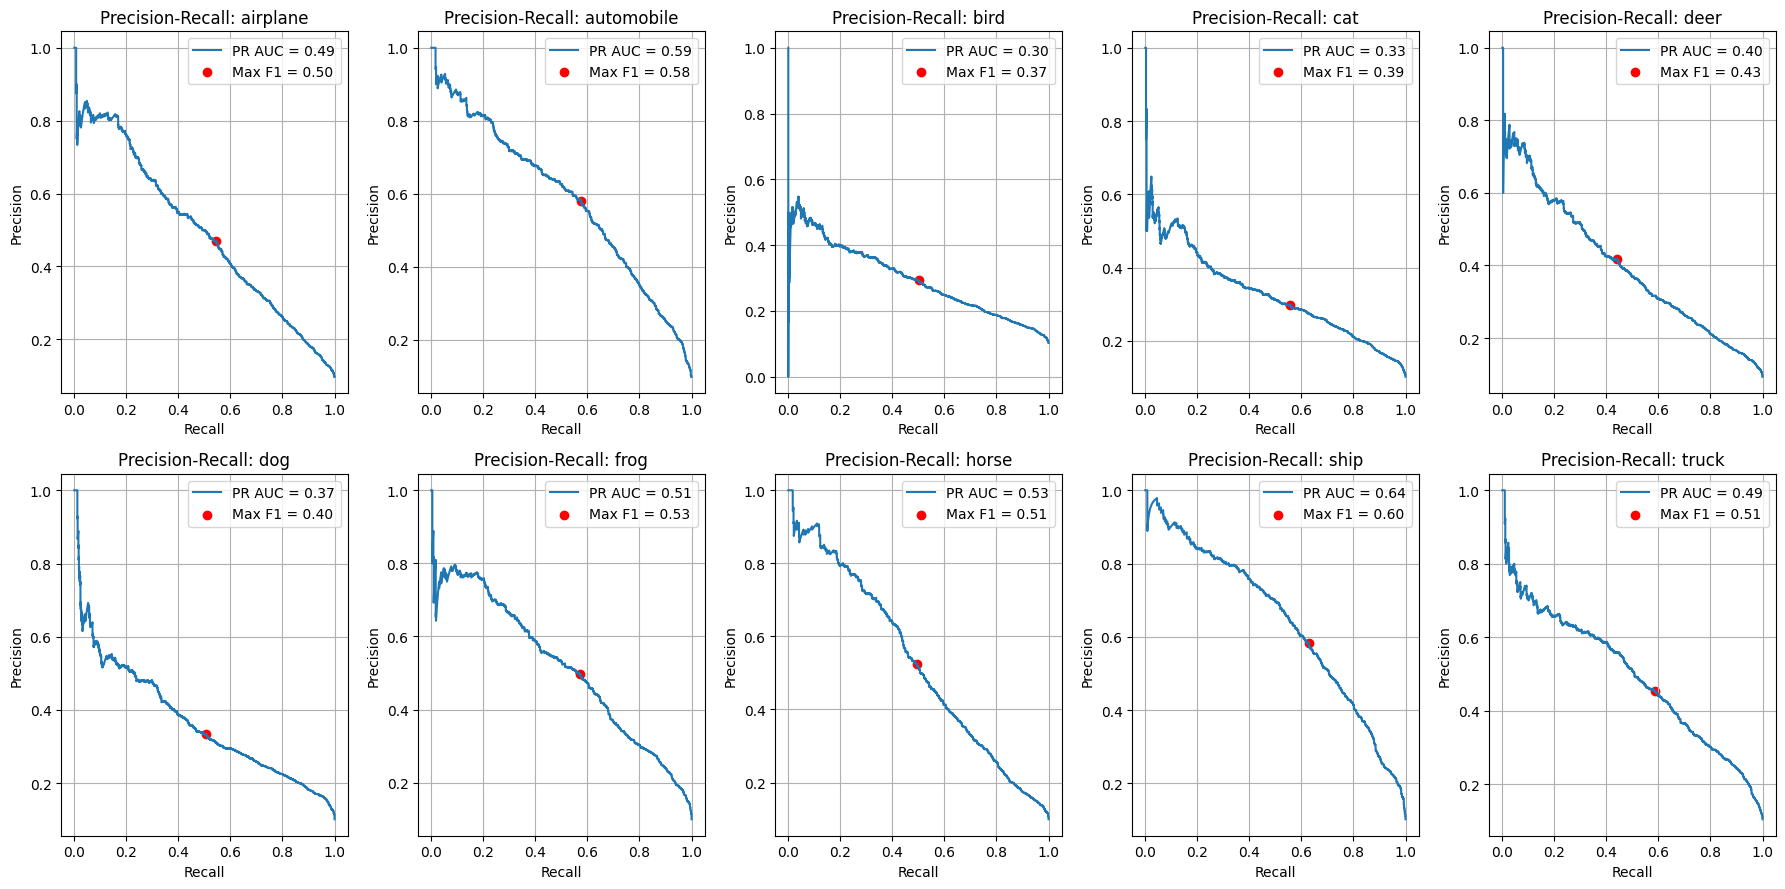

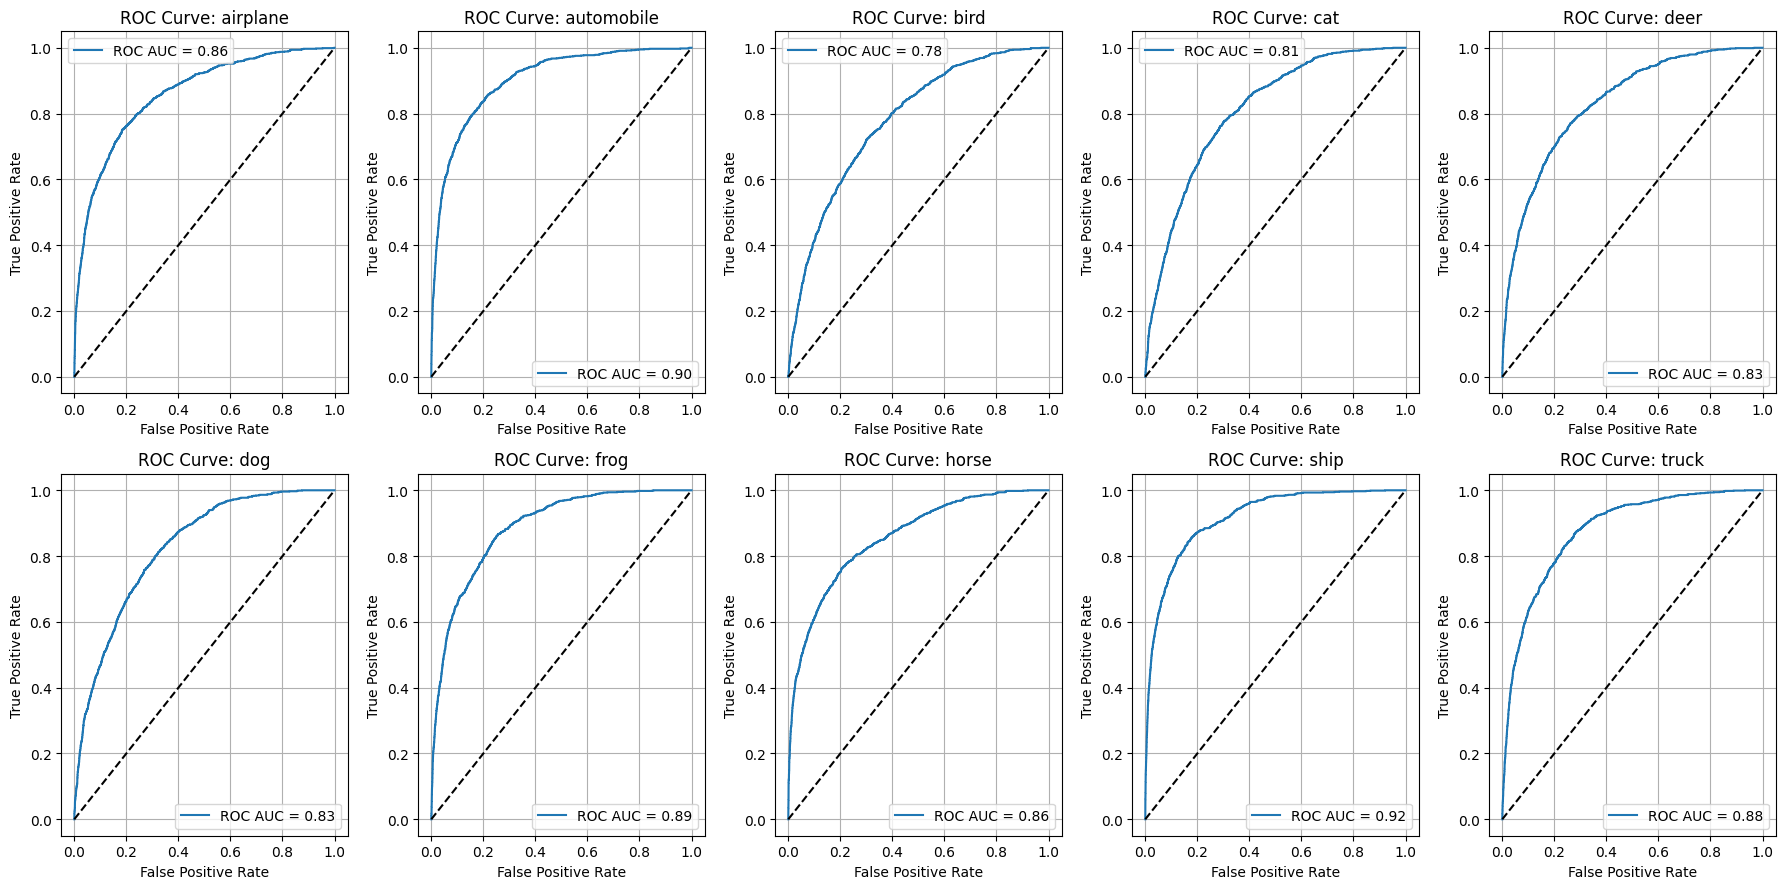

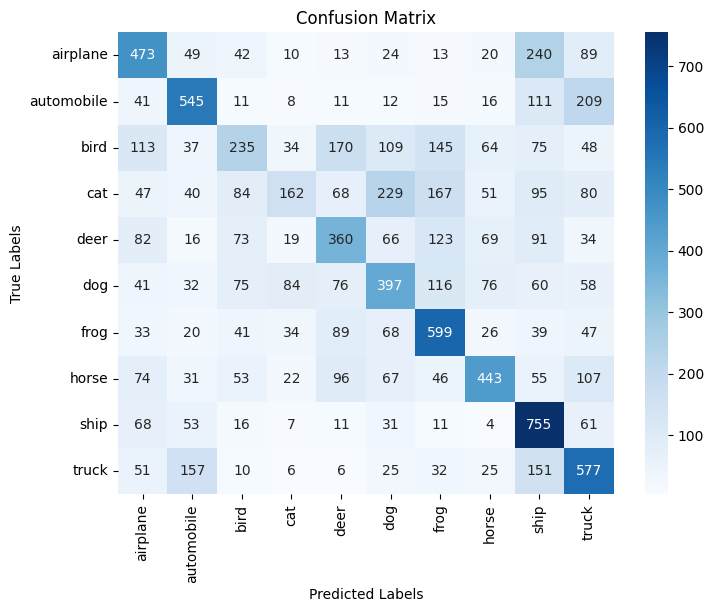


Classification Report:
              precision    recall  f1-score   support

    airplane       0.46      0.49      0.47       973
  automobile       0.56      0.56      0.56       979
        bird       0.37      0.23      0.28      1030
         cat       0.42      0.16      0.23      1023
        deer       0.40      0.39      0.39       933
         dog       0.39      0.39      0.39      1015
        frog       0.47      0.60      0.53       996
       horse       0.56      0.45      0.50       994
        ship       0.45      0.74      0.56      1017
       truck       0.44      0.55      0.49      1040

    accuracy                           0.45     10000
   macro avg       0.45      0.46      0.44     10000
weighted avg       0.45      0.45      0.44     10000



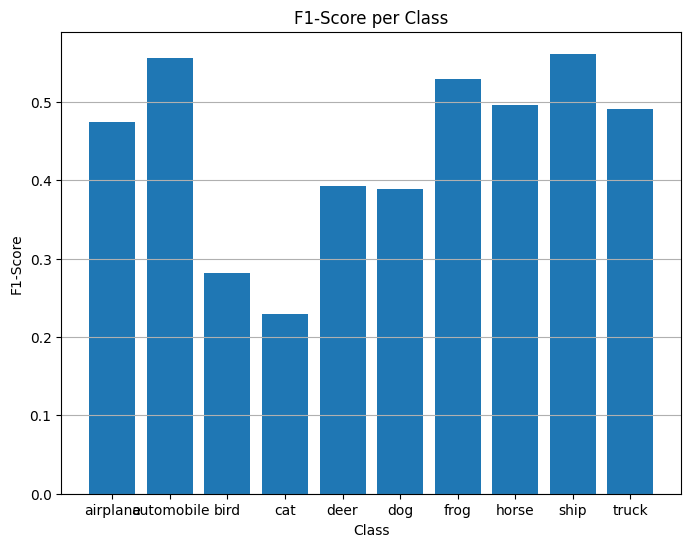

In [ ]:
visualize_model_char(CIFAR10_2layer_NN, x_val=val_scaled, y_val=val_target)

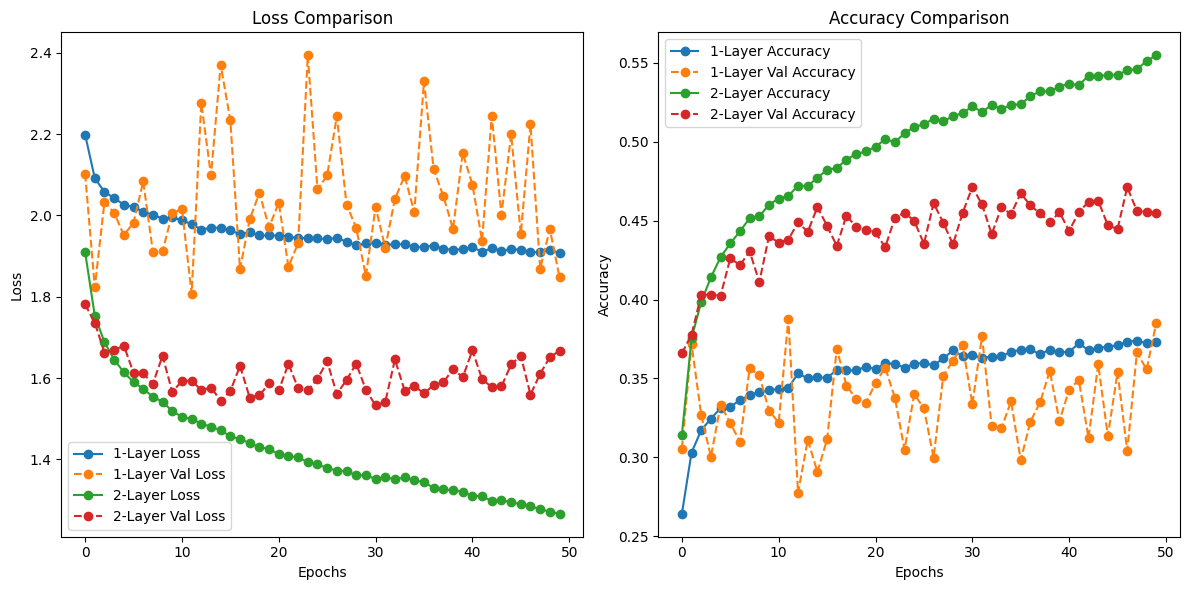

In [ ]:
# Plot loss comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(one_layer_hist.history['loss'], label='1-Layer Loss', marker='o')
plt.plot(one_layer_hist.history['val_loss'], label='1-Layer Val Loss', marker='o', linestyle='--')
plt.plot(two_layer_hist.history['loss'], label='2-Layer Loss', marker='o')
plt.plot(two_layer_hist.history['val_loss'], label='2-Layer Val Loss', marker='o', linestyle='--')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy comparison
plt.subplot(1, 2, 2)
plt.plot(one_layer_hist.history['accuracy'], label='1-Layer Accuracy', marker='o')
plt.plot(one_layer_hist.history['val_accuracy'], label='1-Layer Val Accuracy', marker='o', linestyle='--')
plt.plot(two_layer_hist.history['accuracy'], label='2-Layer Accuracy', marker='o')
plt.plot(two_layer_hist.history['val_accuracy'], label='2-Layer Val Accuracy', marker='o', linestyle='--')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## 옵티마이저

옵티마이저는 신경망의 가중치와 편향을 업데이트하는 알고리즘이다. 옵티마이저의 주요 역할은 다음과 같다.
1. 손실 함수 값 최소화
2. 학습 속도와 안정성 조절\
주요한 옵티마이저의 종류는 다음과 같다.
1. SGD
2. Momentum
3. Adam
4. RMSProp

여기서는 RMSProp를 모델에 추가해 볼것이다.

In [ ]:
CIFAR10_opt = Sequential(
    [Input(shape=(train_scaled.shape[1:])),
    Dense(100, activation='sigmoid', name='Dense_1'),
    Dense(10, activation='softmax', name='Dense_2')],
    name='CIFAR10_opt')

CIFAR10_opt.summary()

Model: "CIFAR10_opt"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Dense_1 (Dense)                      │ (None, 100)                 │         307,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 308,310 (1.18 MB)

 Trainable params: 308,310 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
CIFAR10_opt.compile(
    optimizer='RMSProp',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
two_layer_with_opt = CIFAR10_opt.fit(
    train_scaled, train_target,
    epochs=50,
    validation_data=(val_scaled, val_target),
    batch_size=32,
    verbose=0)

In [ ]:
CIFAR10_opt.save(save_dir / 'model2.keras')
save_history_to_json(two_layer_with_opt, save_dir, 'model2_history.json')

History successfully saved to /content/Mydrive/MyDrive/object detection datasets/CIFAR10/Model/model2_history.json


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


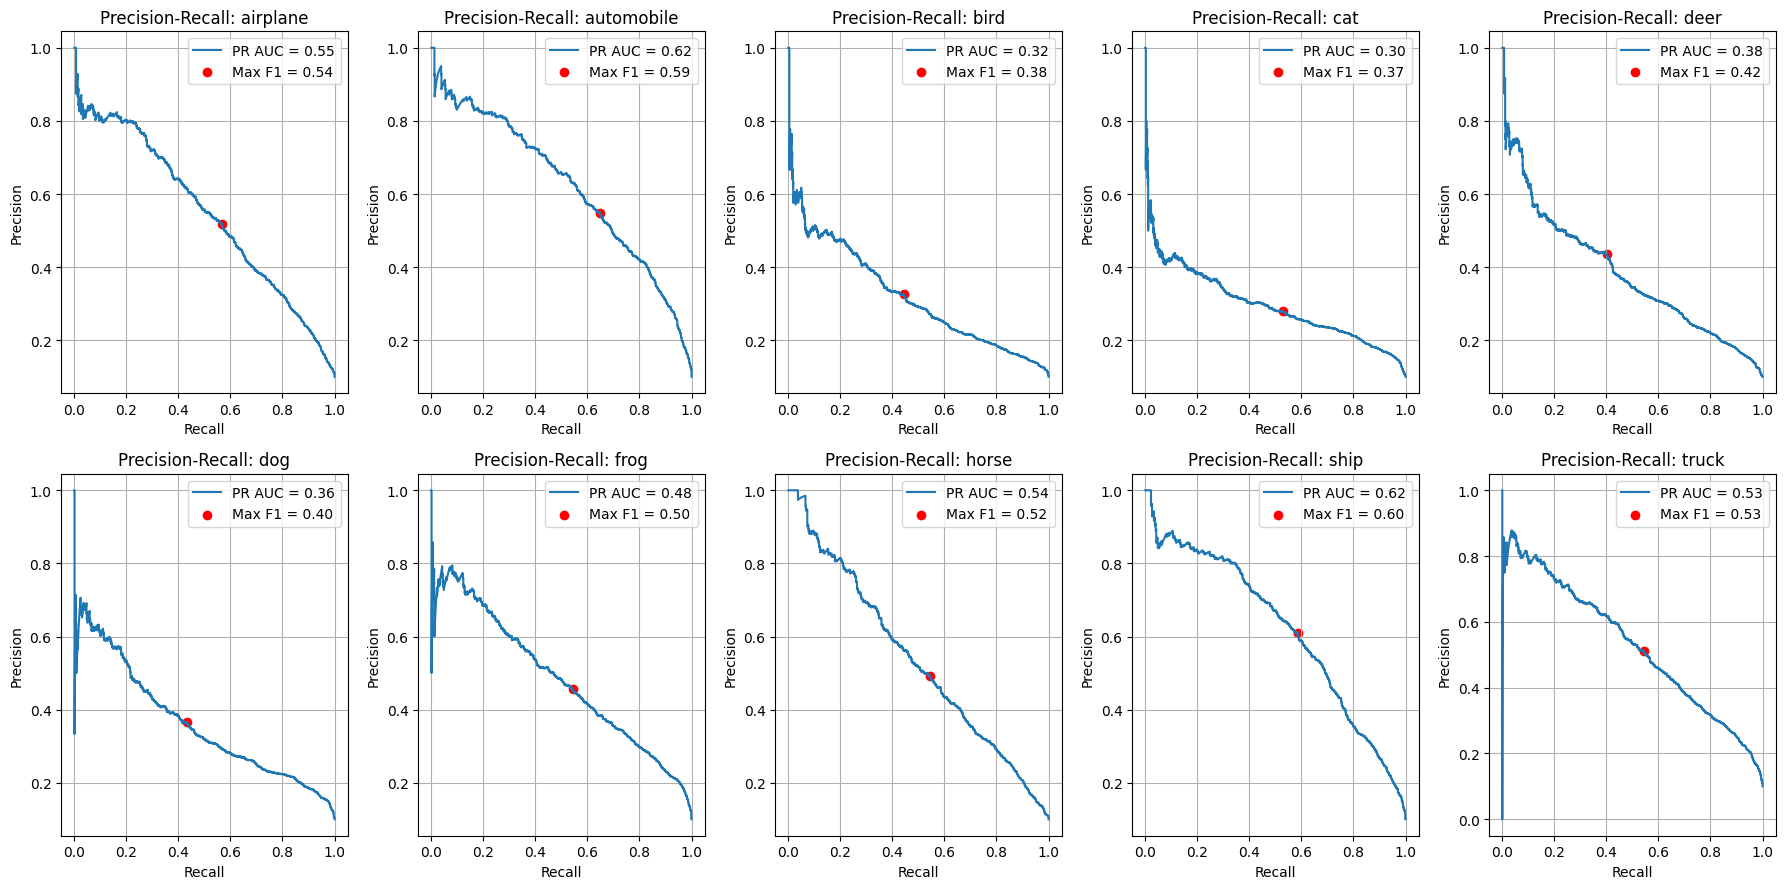

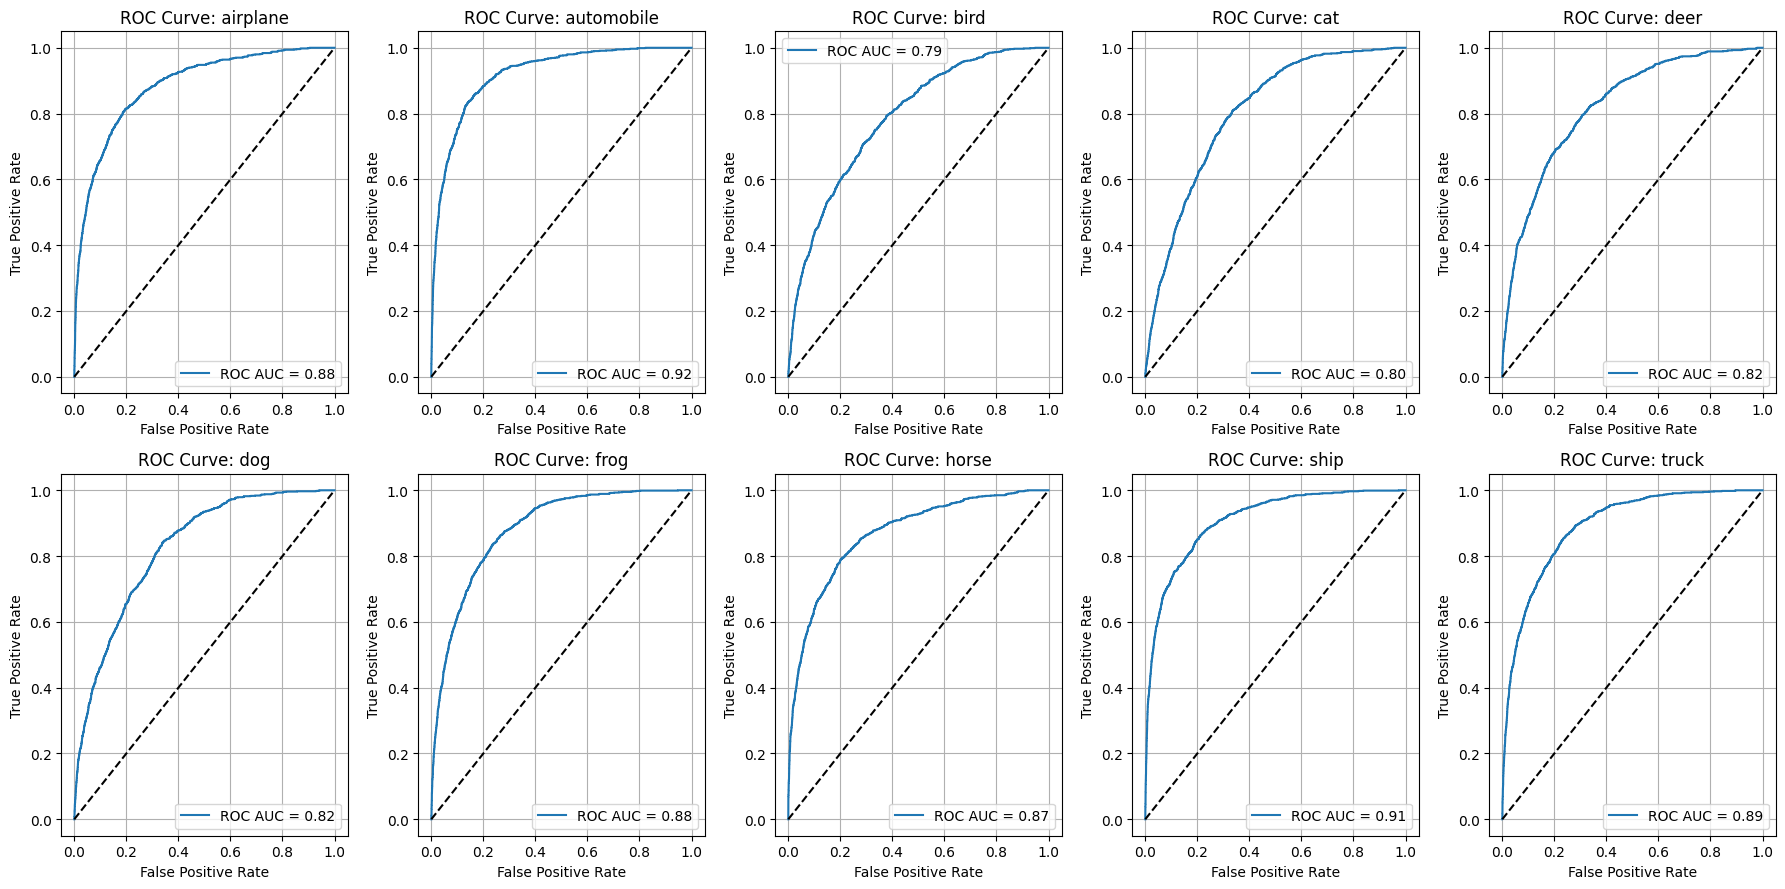

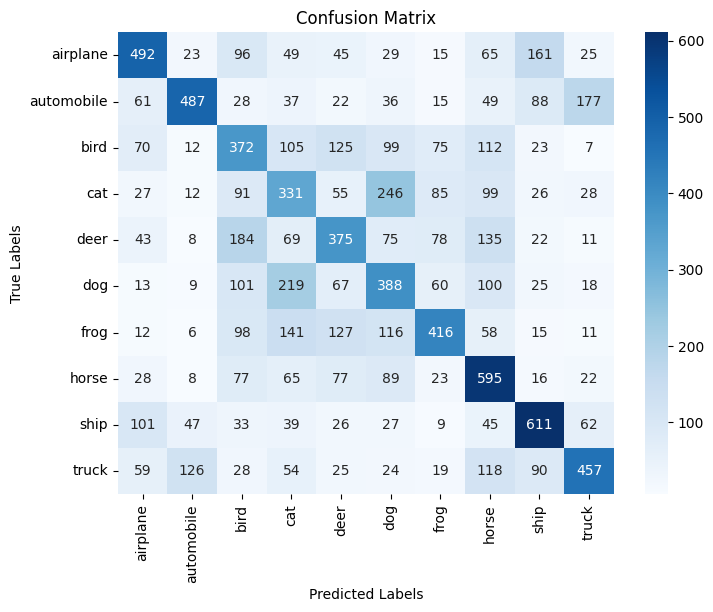


Classification Report:
              precision    recall  f1-score   support

    airplane       0.54      0.49      0.52      1000
  automobile       0.66      0.49      0.56      1000
        bird       0.34      0.37      0.35      1000
         cat       0.30      0.33      0.31      1000
        deer       0.40      0.38      0.39      1000
         dog       0.34      0.39      0.36      1000
        frog       0.52      0.42      0.46      1000
       horse       0.43      0.59      0.50      1000
        ship       0.57      0.61      0.59      1000
       truck       0.56      0.46      0.50      1000

    accuracy                           0.45     10000
   macro avg       0.47      0.45      0.45     10000
weighted avg       0.47      0.45      0.45     10000



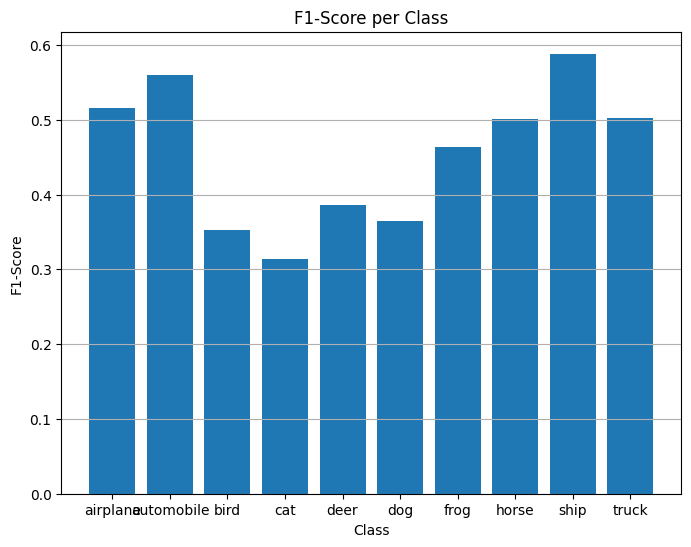

In [ ]:
visualize_model_char(CIFAR10_opt, x_val=test_scaled, y_val=test_target)

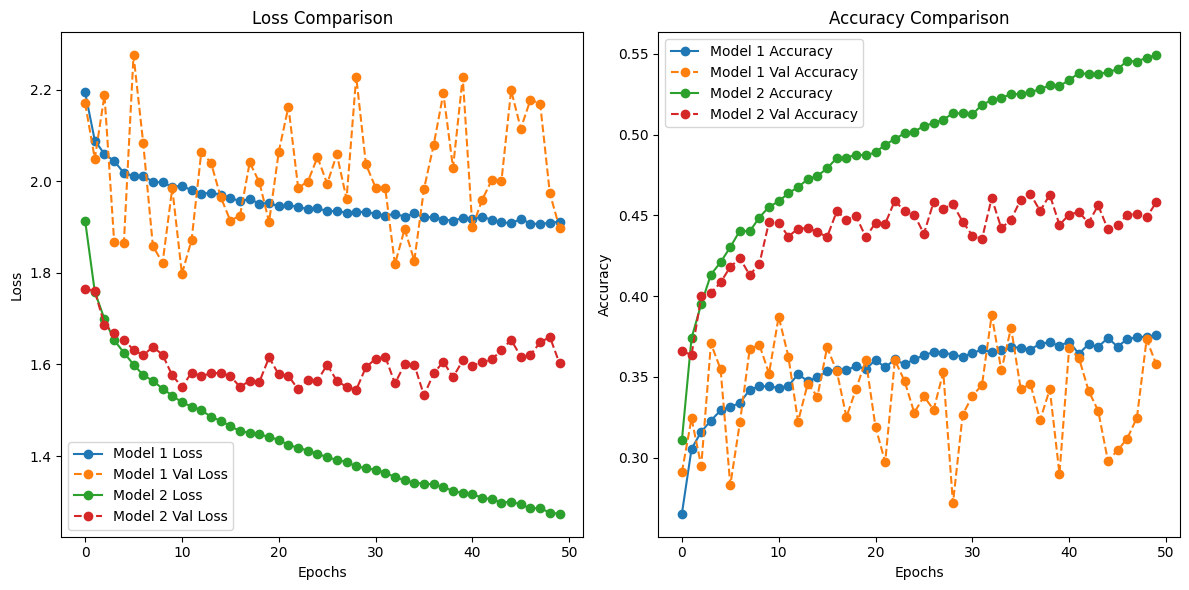

In [ ]:
# Plot loss comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(one_layer_hist.history['loss'], label='Model 1 Loss', marker='o')
plt.plot(one_layer_hist.history['val_loss'], label='Model 1 Val Loss', marker='o', linestyle='--')
plt.plot(two_layer_with_opt.history['loss'], label='Model 2 Loss', marker='o')
plt.plot(two_layer_with_opt.history['val_loss'], label='Model 2 Val Loss', marker='o', linestyle='--')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy comparison
plt.subplot(1, 2, 2)
plt.plot(one_layer_hist.history['accuracy'], label='Model 1 Accuracy', marker='o')
plt.plot(one_layer_hist.history['val_accuracy'], label='Model 1 Val Accuracy', marker='o', linestyle='--')
plt.plot(two_layer_with_opt.history['accuracy'], label='Model 2 Accuracy', marker='o')
plt.plot(two_layer_with_opt.history['val_accuracy'], label='Model 2 Val Accuracy', marker='o', linestyle='--')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


옵티마이저를 추가한 결과, 손실이 더욱 감소하고, 정확도가 더 높은 값에 도달했다.\
\
레이어와 옵티마이저만을 더 추가했을 뿐인데 성능이 대략 50% 넘게 향상되었다. 심지어 같은 에포크에 성능 증가폭이 감소하는 경향도 보이지 않는다. \
\
하지만 레이어 추가로 인한 성능 향상은 무한하지 않을 것이다. 계산 비용과 학습 시간의 증가로 인해 현실적으로 한계도 있을 것이다. 따라서  레이어를 늘리는 대신 적합한 모델을 다시 선택해야한다는 판단을 할 수 있다.

## 합성곱 신경망

**합성곱(Convolution)**은 입력 데이터와 커널(필터) 간의 곱셈과 합산을 통해 새로운 특징 맵을 생성하는 연산이다. 이를 통해 입력 데이터로부터 다양한 특징을 추출할 수 있다. 일반적인 2D 합성곱은 다음과 같이 정의된다.
$$S(i, j) = (I * K)(i, j) = ∑_m ∑_n I(m, n) * K(i - m, j - n)$$
* $S(i, j)$: 출력 특징 맵의 원소
* $I$: 입력 데이터
* $K$: 커널(필터)
* $i$ 와 $j$: 출력 특징 맵의 인덱스
* $m$ 과 $n$: 입력 데이터의 인덱스
이 과정은 입력 데이터를 필터와 겹쳐지는 부분에서 곱셈하고, 그 결과를 모두 합산해 새로운 값을 생성하는 것이다. 이렇게 합성곱을 통해 특징 맵을 생성하면, 입력 데이터에서 다양한 특징을 감지할 수 있다.\
\
합성곱 층의 뉴런에 있는 가중치 개수는 정하기 나름이다. 즉 하이퍼파라미터이다. 이를 비유하자면, 입력 데이터 위를 이동하면서 같은 도장(필터, 커널)으로 하나씩 찍는 것 처럼 생각할 수 있다. 도장을 찍을 때마다 출력이 하나씩 만들어지는 것이다.

**합성곱 신경망(Convolution Neural Network, CNN)**에서는 완전 신경망과 달리 뉴런을 **필터(Filter)**라고 부른다. 혹은 커널(Kernel)**이라고도 부른다. 여기서 완전 신경망이란 완전 연결 층(밀집층)만 사용해 만든 신경망을 말한다.\
\
커널와 필터 간 약간의 의미적 차이는 다음과 같다.
1. 필터(Filter):
 * 종류 및 목적: '필터'는 일반적으로 이미지나 신호 등에서 특정한 정보를 추출하거나 변경하기 위해 사용되는 연산자를 의미. 이미지프로세싱에서는 특정 패턴, 특징, 노이즈 등을 감지하거나 강조하는 데 사용.
 * 적용 영역: '필터'는 이미지 처리에서 주로 사용되며, 경계 감지, 흐림 효과 등 다양한 작업에 적용될 수 있음.

2. 커널(Kernel):
 * 종류 및 목적: '커널'은 주로 신경망에서 사용되는 용어, 합성곱 연산에 쓰인느 작은 행렬 또는 윈도우를 의미.
 * 적용 영역: 커널은 주로 딥러닝에 사용, 합성곱 연산을 통해 입력 데이터에서 특징을 추출하는 데 활용.

합성곱 계산을 통해 얻은 출력을 특별히 **특성 맵(Feature Map)**이라고 부른다.\
밀집층에 있는 뉴런의 가중치가 모두 다르듯이 합성곱 층에 있는 필터의 가중치(커널)모두 다르다. 실제 계산은 밀집층과 동일하게 단순히 입력과 가중치를 곱하는 것이지만 입력차원 형태를 유지하는 점이 다르다. 또 입력보다 훨씬 작은 크기의 커널을 사용하고 입력 위를 이동하며 입력차원 특성 맵을 만든다. 이렇게 입력차원 구조를 그대로 사용하기 때문에 합성곱 신경망이 이미지 처리 분야에서 뛰어난 성능을 발휘한다.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.datasets import cifar10

# 데이터 불러오기
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 데이터 확인
print(f"x_train shape: {x_train.shape}" )
print(f"y_train shape: {y_train.shape}" )
print(f"x_test shape: {x_test.shape}" )
print(f"y_test shape: {y_test.shape}" )

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [ ]:
from sklearn.model_selection import train_test_split

train_scaled = x_train / 255.0
test_scaled = x_test / 255.0
train_target = tf.keras.utils.to_categorical(y_train)
test_target = tf.keras.utils.to_categorical(y_test)

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

train_target = np.argmax(train_target, axis=1)
val_target = np.argmax(val_target, axis=1)
test_target =np.argmax(test_target, axis=1)

print(f'train_scaled shape: {train_scaled.shape}')
print(f'val_scaled shape: {val_scaled.shape}')
print(f'test_scaled shape: {test_scaled.shape}')
print()
print(f'train_target shape: {train_target.shape}')
print(f'val_target shape: {val_target.shape}')
print(f'test_target shape: {test_target.shape}')

train_scaled shape: (40000, 32, 32, 3)
val_scaled shape: (10000, 32, 32, 3)
test_scaled shape: (10000, 32, 32, 3)

train_target shape: (40000,)
val_target shape: (10000,)
test_target shape: (10000,)


LeNet 5를 참고해서 합성곱 신경망 모델을 구축해보자.

In [ ]:
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam


cnn = Sequential(
    name='LeNet_5',
    layers=[
    Input(shape=(train_scaled.shape[1:]), name='Input'),
    Conv2D(6, (5, 5), padding='valid', activation='relu', name='C1'),
    MaxPooling2D(pool_size=(2, 2), name='S2'),
    Conv2D(16, (5, 5), padding='valid', activation='relu', name='C3'),
    MaxPooling2D(pool_size=(2, 2), name='S4'),
    Conv2D(120, (5, 5), padding='valid', activation='relu', name='C5'),
    Flatten(name='Flatten'),
    Dense(84, activation='relu', name='FC6'),
    Dense(10, activation='softmax', name='Output')
    ]
)

cnn.summary()

Model: "LeNet_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ C1 (Conv2D)                          │ (None, 28, 28, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ S2 (MaxPooling2D)                    │ (None, 14, 14, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ C3 (Conv2D)                          │ (None, 10, 10, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ S4 (MaxPooling2D)                    │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ C5 (Conv2D)                          │ (None, 1, 1, 120)           │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (Flatten)                    │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC6 (Dense)                          │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 10)                  │             850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,006 (242.21 KB)

 Trainable params: 62,006 (242.21 KB)

 Non-trainable params: 0 (0.00 B)

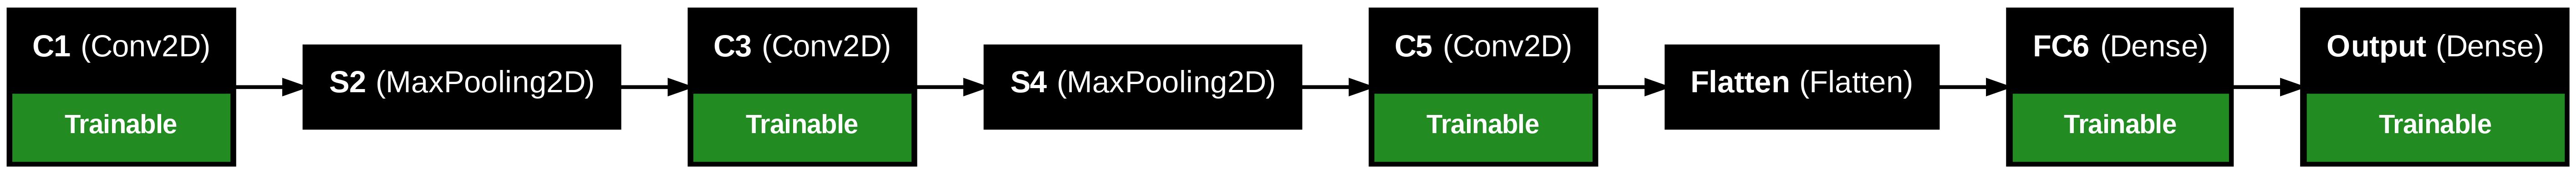

In [ ]:
keras.utils.plot_model(cnn, to_file='cnn_model.png', show_layer_names=True, dpi=300, show_trainable=True, rankdir='LR')

In [ ]:
cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
cnn_hist = cnn.fit(
    train_scaled, train_target,
    batch_size=128, epochs=50,
    validation_data=(val_scaled, val_target),
    verbose=0)

In [ ]:
cnn.save(save_dir / 'model3.keras')
save_history_to_json(cnn_hist, save_dir, 'model3_history.json')

History successfully saved to /content/Mydrive/MyDrive/object detection datasets/CIFAR10/Model/model3_history.json


위의 인공신경망에서 마지막에 만든 모델인 `two_layer_with_opt`와 비교해보자.

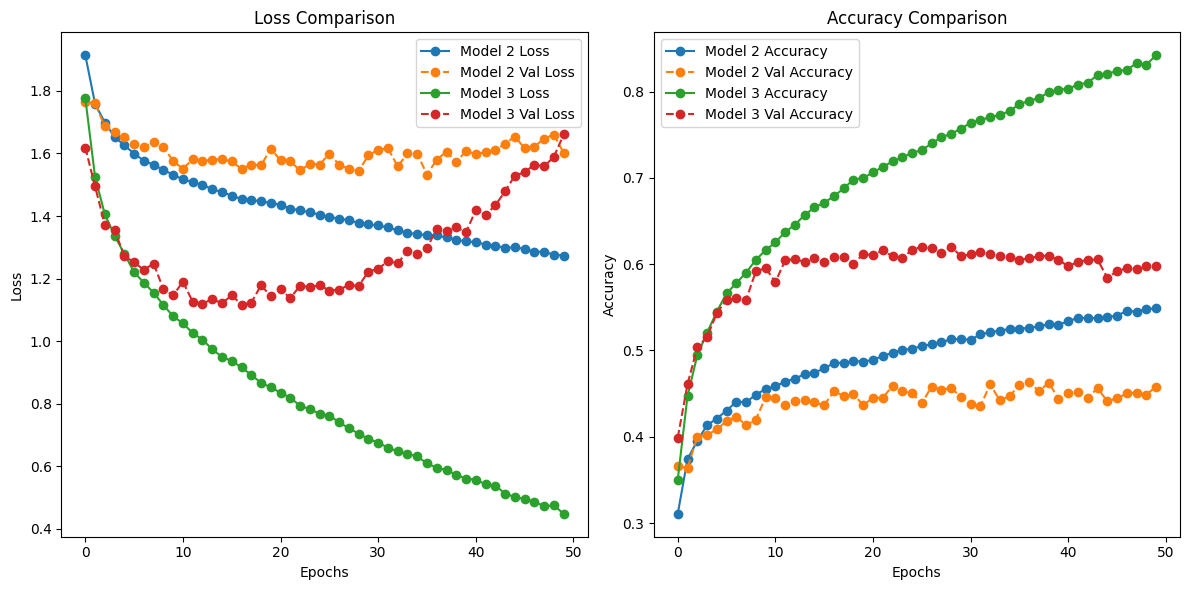

In [ ]:
# 손실 비교
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(two_layer_with_opt.history['loss'], label='Model 2 Loss', marker='o')
plt.plot(two_layer_with_opt.history['val_loss'], label='Model 2 Val Loss', marker='o', linestyle='--')
plt.plot(cnn_hist.history['loss'], label='Model 3 Loss', marker='o')
plt.plot(cnn_hist.history['val_loss'], label='Model 3 Val Loss', marker='o', linestyle='--')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 비교
plt.subplot(1, 2, 2)
plt.plot(two_layer_with_opt.history['accuracy'], label='Model 2 Accuracy', marker='o')
plt.plot(two_layer_with_opt.history['val_accuracy'], label='Model 2 Val Accuracy', marker='o', linestyle='--')
plt.plot(cnn_hist.history['accuracy'], label='Model 3 Accuracy', marker='o')
plt.plot(cnn_hist.history['val_accuracy'], label='Model 3 Val Accuracy', marker='o', linestyle='--')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


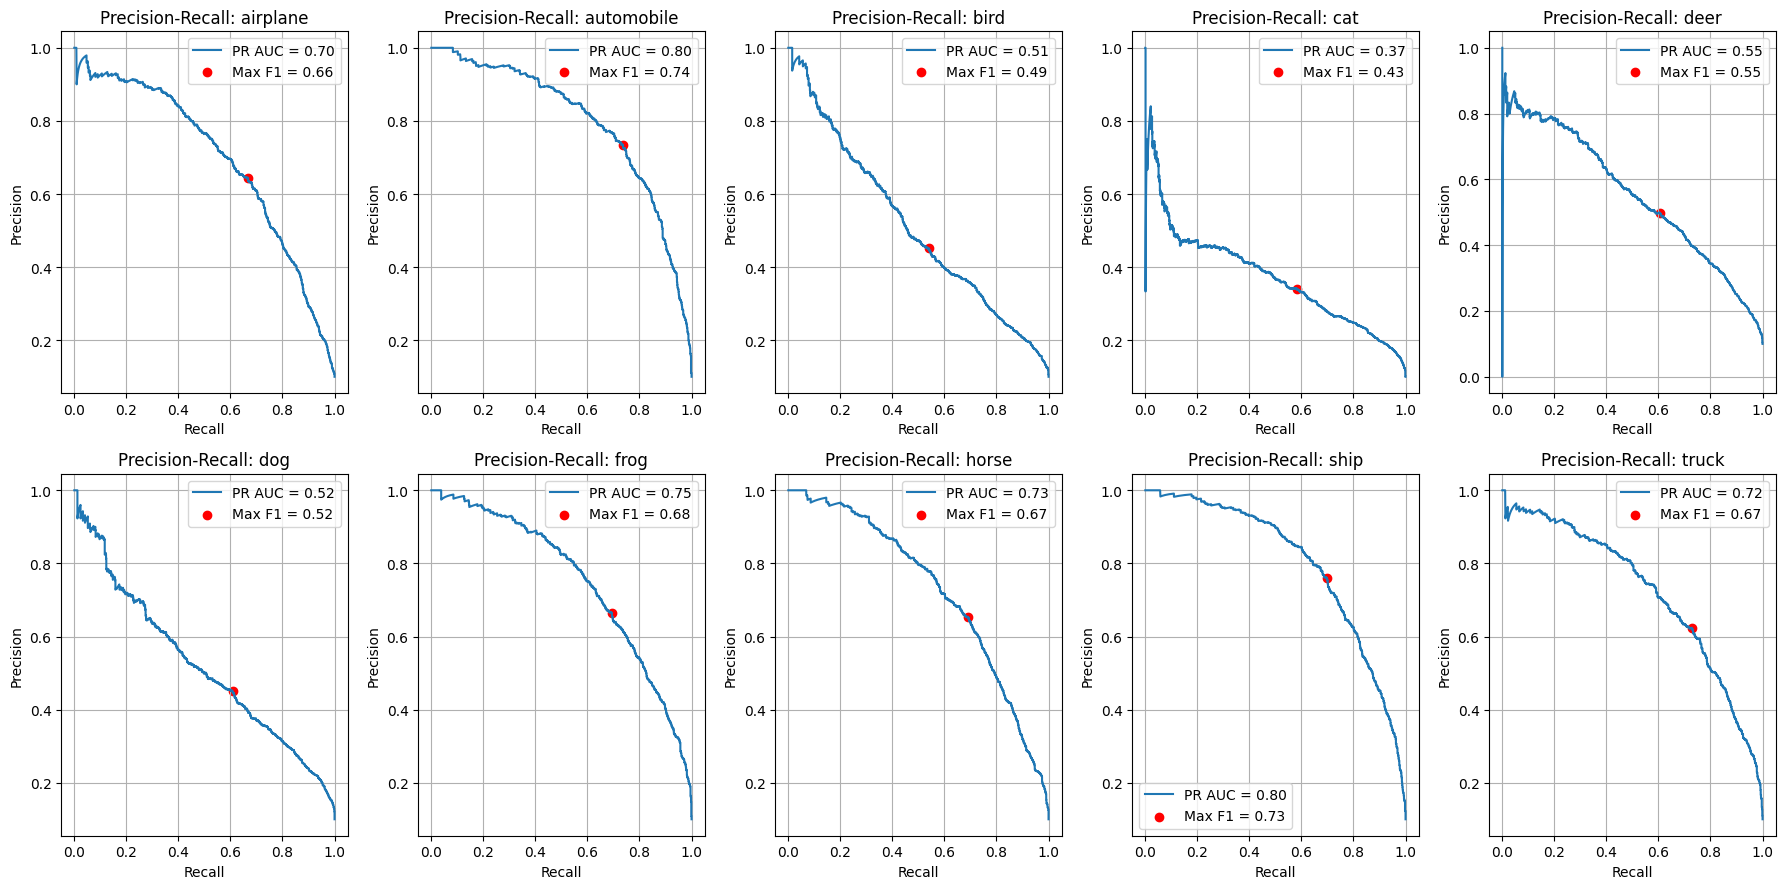

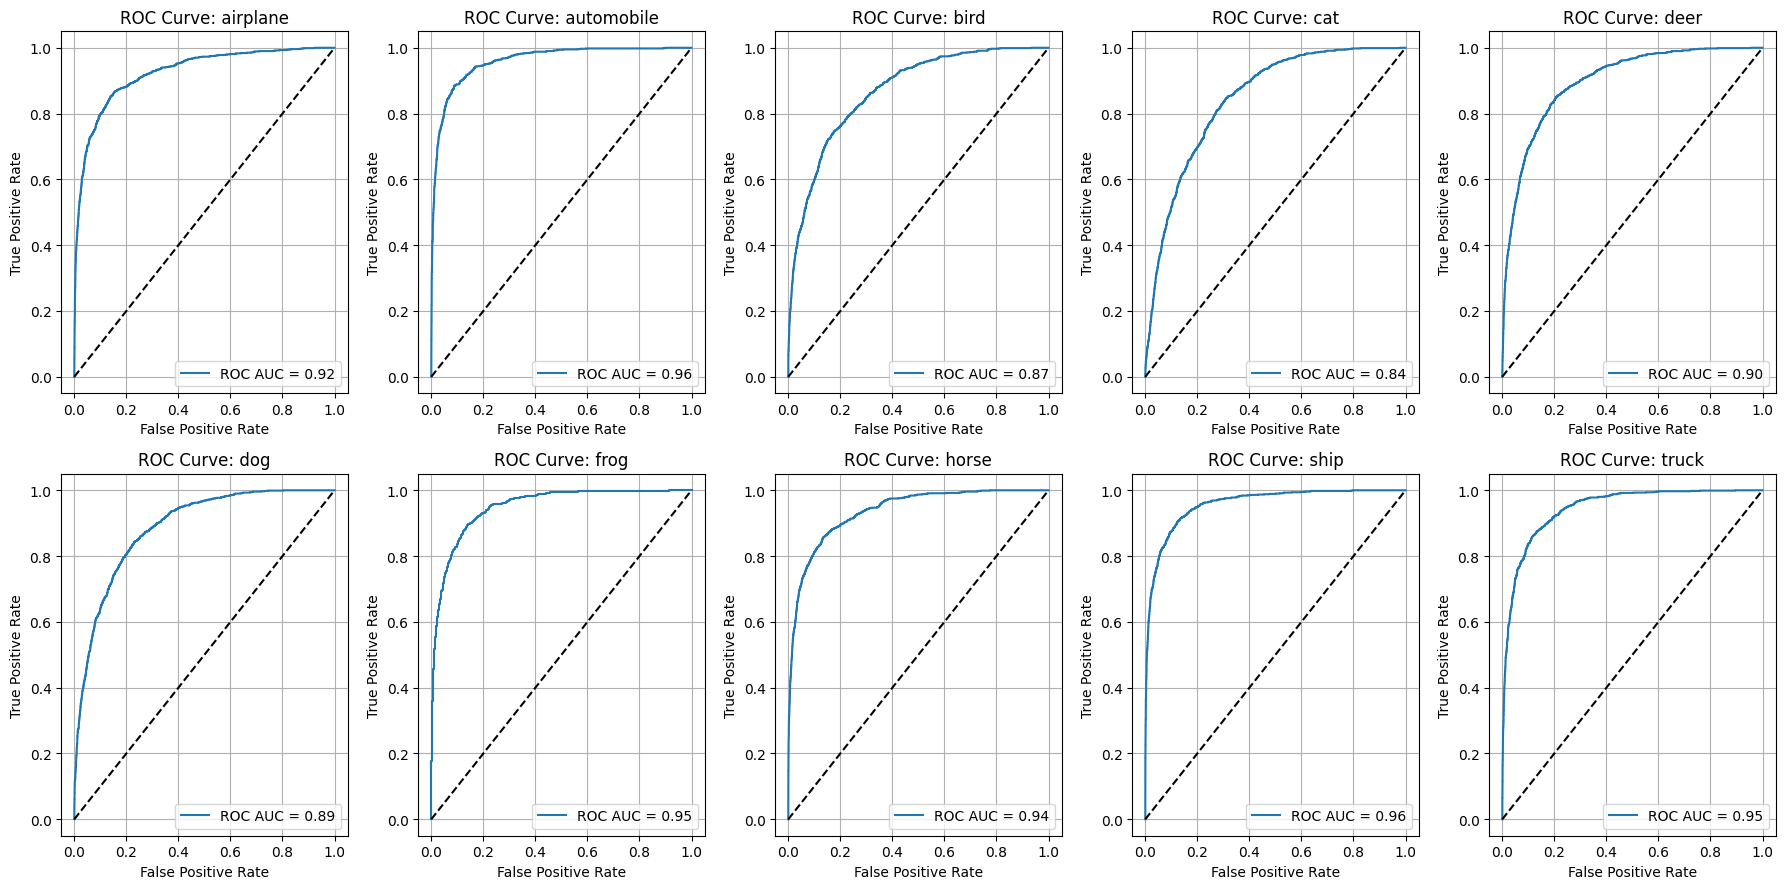

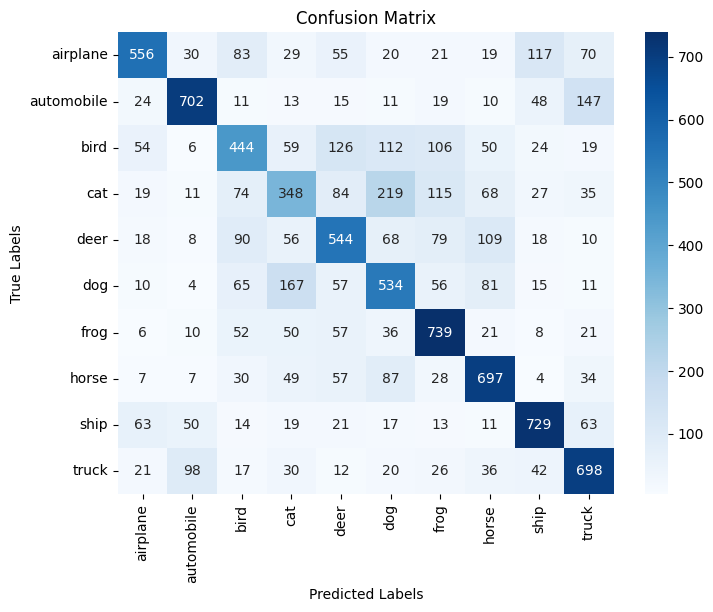


Classification Report:
              precision    recall  f1-score   support

    airplane       0.71      0.56      0.63      1000
  automobile       0.76      0.70      0.73      1000
        bird       0.50      0.44      0.47      1000
         cat       0.42      0.35      0.38      1000
        deer       0.53      0.54      0.54      1000
         dog       0.48      0.53      0.50      1000
        frog       0.61      0.74      0.67      1000
       horse       0.63      0.70      0.66      1000
        ship       0.71      0.73      0.72      1000
       truck       0.63      0.70      0.66      1000

    accuracy                           0.60     10000
   macro avg       0.60      0.60      0.60     10000
weighted avg       0.60      0.60      0.60     10000



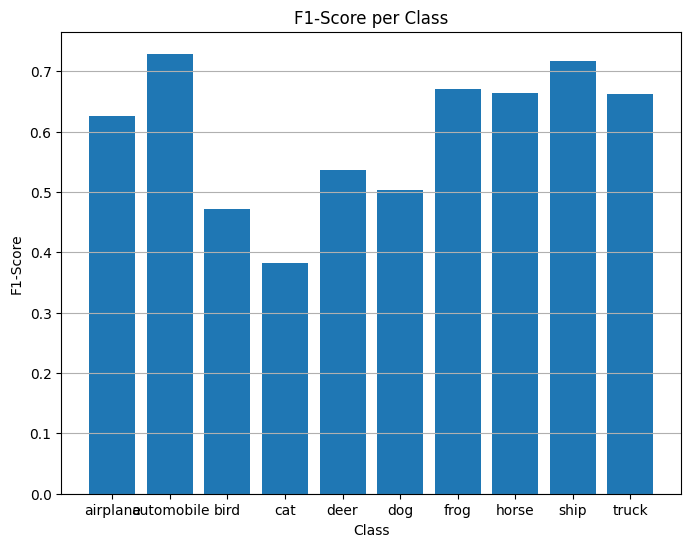

In [ ]:
visualize_model_char(cnn, x_val=test_scaled, y_val=test_target)

## 과대적합


마지막 모델이 기존 모델보다 좋다는것은 확인할 수 있다. 하지만 문제가 보인다.\
\
위 플롯을 봤을 때 훈련 정확성은 에포크가 지남에 따라 선형적으로 증가하는 반면, 검증 정확성은 거의 증가하지 못한다. 또한 훈련 정확성과 검증 정확성간의 차이가 점점 벌어지고 있다. 이는 **과대적합**의 징후로 볼 수 있다.\
\
훈련 예제가 적을 때 모델은 새로운 예제에서 모델의 성능에 부정적인 영향을 미치는 정도까지 훈련 예제의 노이즈나 원하지 않는 세부까지 학습한다. 이로인해 모델이 새 데이터세트에서 일반화하는데 어려움이 있음을 볼 수 있다.\
\
훈련 과정에서 과대적합을 막는 여러가지 방법들이 있다. 대표적으로는 L2규제, 드롭아웃, 데이터 증강이 있다.

### 드롭아웃

In [ ]:
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Conv2D, GlobalAvgPool2D, Dropout, MaxPooling2D
from keras.optimizers import Adam

dpout = Sequential(
    name='dpout',
    layers=[
        Input(shape=(train_scaled.shape[1:]), name='Input'),
        Conv2D(32, (3, 3), padding='same', activation='relu', name='C1'),
        MaxPooling2D(pool_size=(2, 2),name='S2'),
        Dropout(0.25, name='D3'),
        Conv2D(64, (3, 3), padding='same', activation='relu', name='C4'),
        Conv2D(64, (3, 3), padding='same', activation='relu', name='C5'),
        MaxPooling2D(pool_size=(2, 2), name='S6'),
        Dropout(0.25, name='D7'),
        Flatten(name='Flatten'),
        Dense(512, activation='leaky_relu', name='FC8'),
        Dropout(0.5, name='D9'),
        Dense(10, activation='softmax', name='Output')
    ])

dpout.summary()

Model: "dpout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ C1 (Conv2D)                          │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ S2 (MaxPooling2D)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ D3 (Dropout)                         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ C4 (Conv2D)                          │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ C5 (Conv2D)                          │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ S6 (MaxPooling2D)                    │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ D7 (Dropout)                         │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC8 (Dense)                          │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ D9 (Dropout)                         │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,159,114 (8.24 MB)

 Trainable params: 2,159,114 (8.24 MB)

 Non-trainable params: 0 (0.00 B)

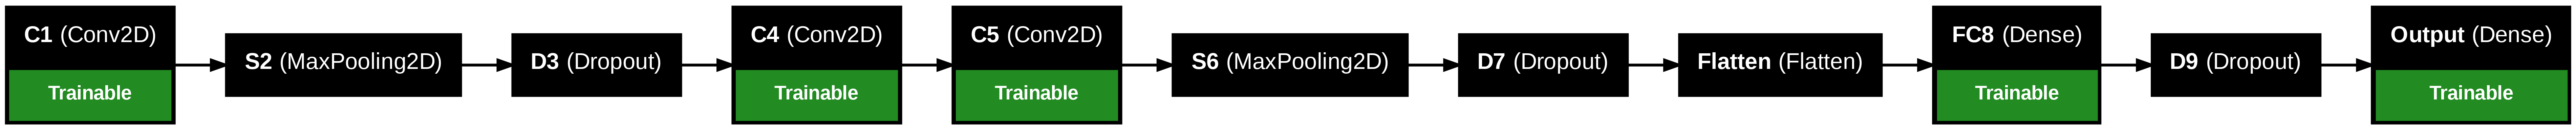

In [ ]:
keras.utils.plot_model(dpout, to_file='dpout_model.png', show_layer_names=True, dpi=300, show_trainable=True, rankdir='LR')

In [ ]:
dpout.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
dpout_hist = dpout.fit(
    train_scaled, train_target,
    batch_size=128, epochs=50,
    validation_data=(val_scaled, val_target),
    verbose=0)

In [ ]:
dpout.save(save_dir / 'model4.keras')
save_history_to_json(dpout_hist, save_dir, 'model4_history.json')

History successfully saved to /content/Mydrive/MyDrive/object detection datasets/CIFAR10/Model/model4_history.json


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


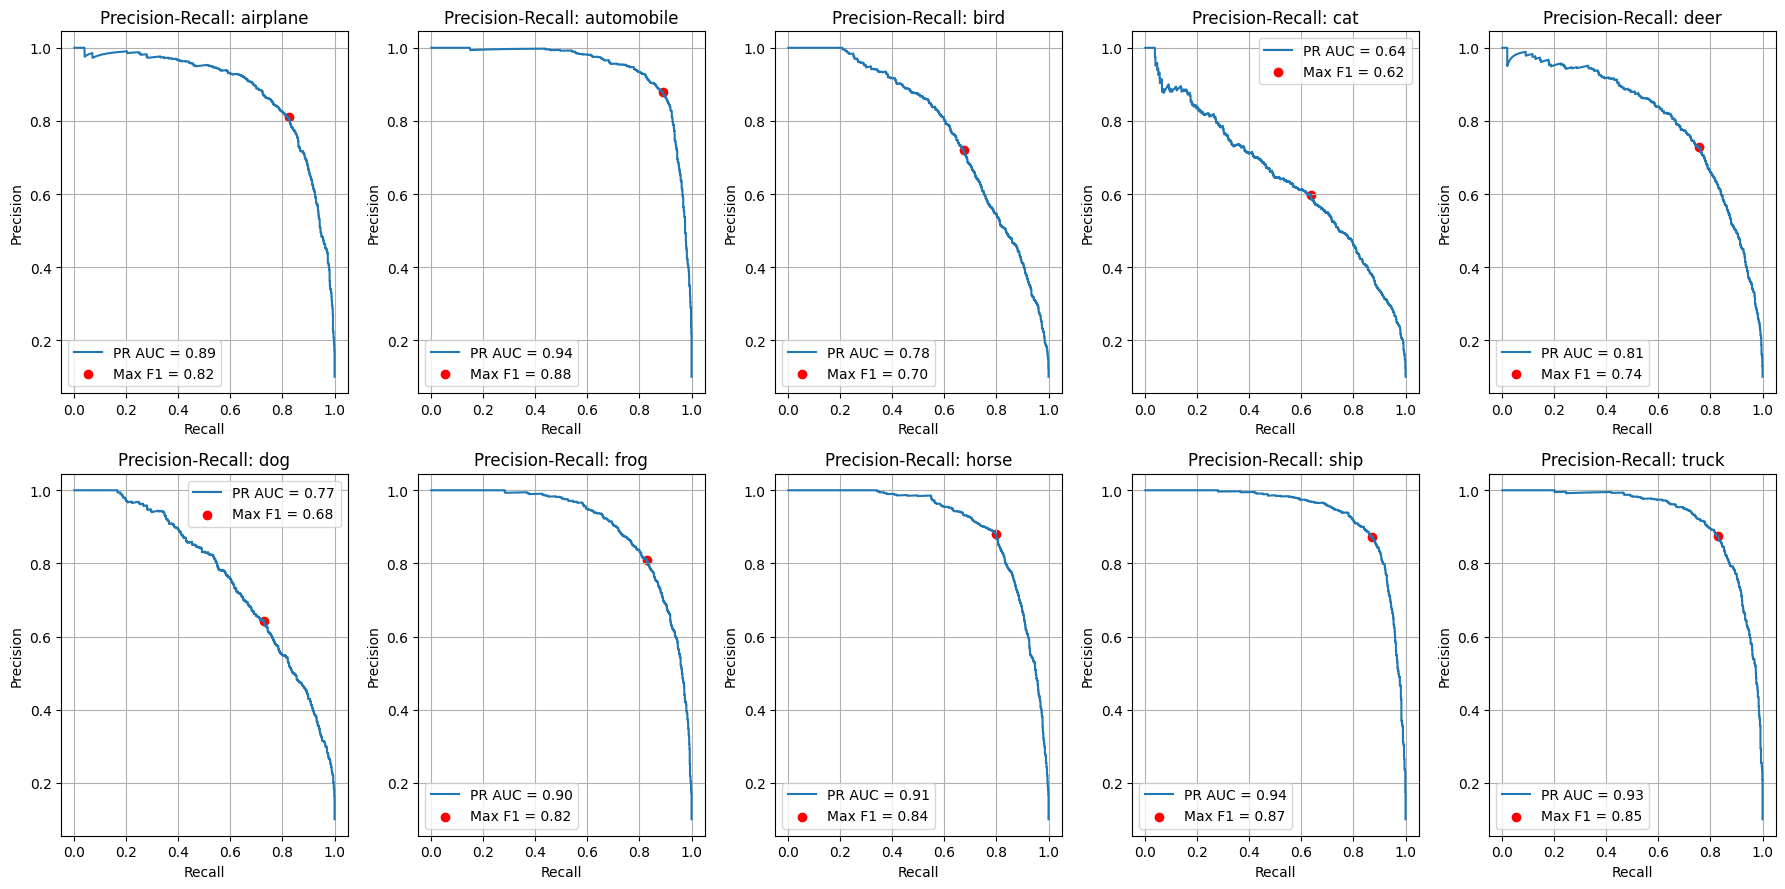

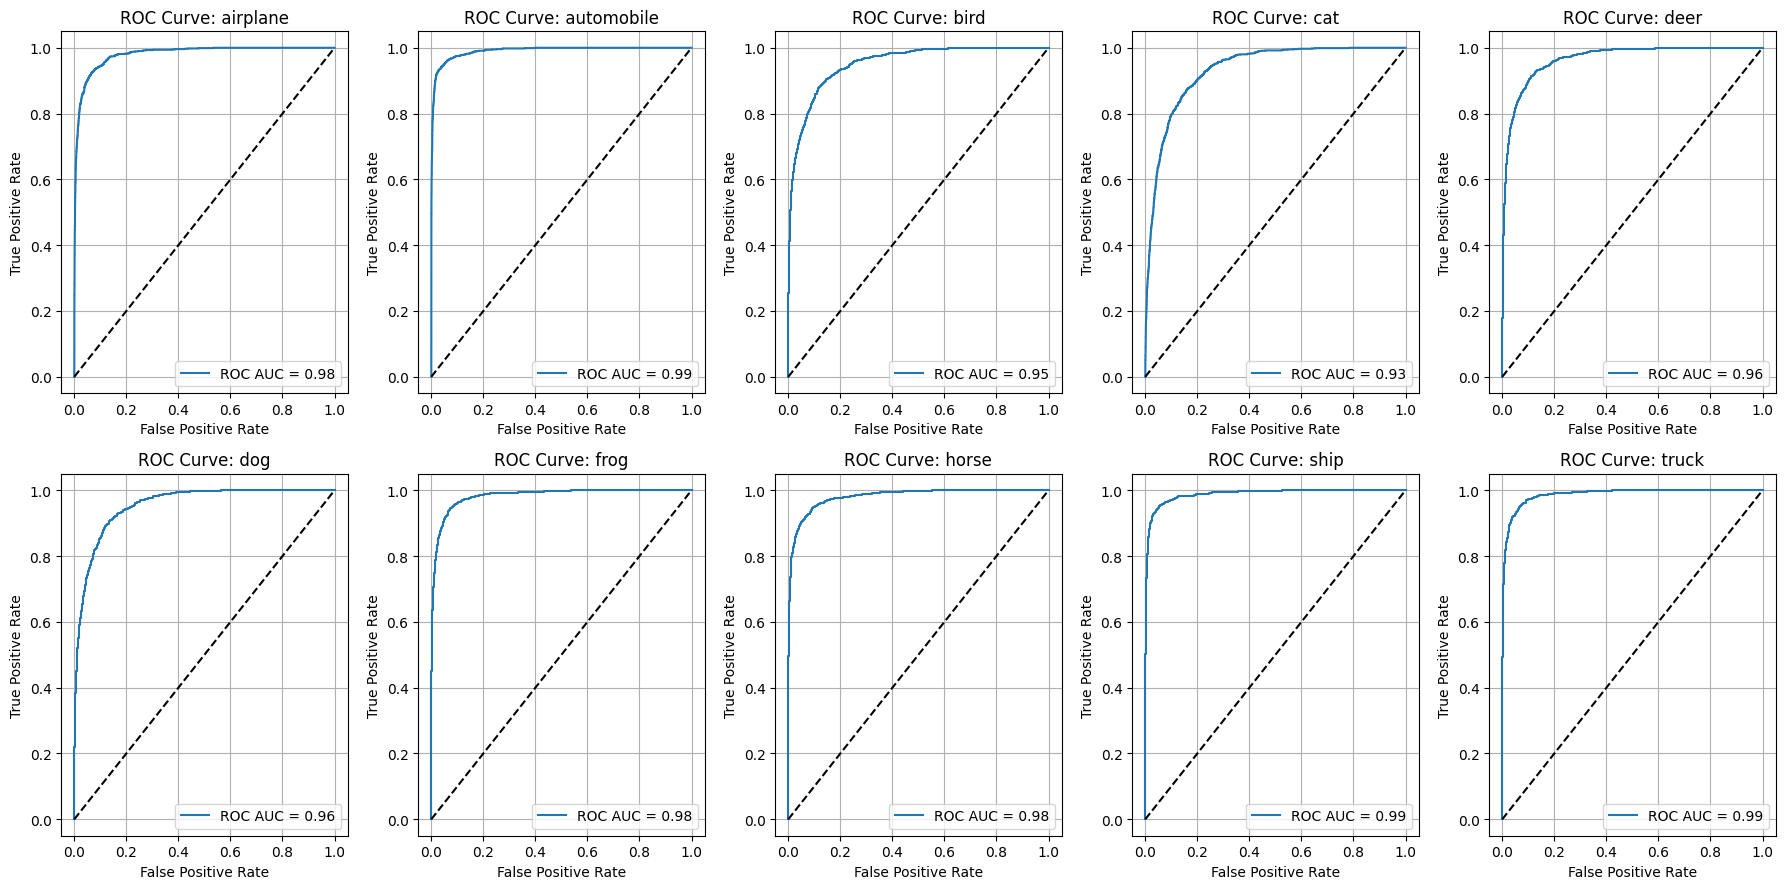

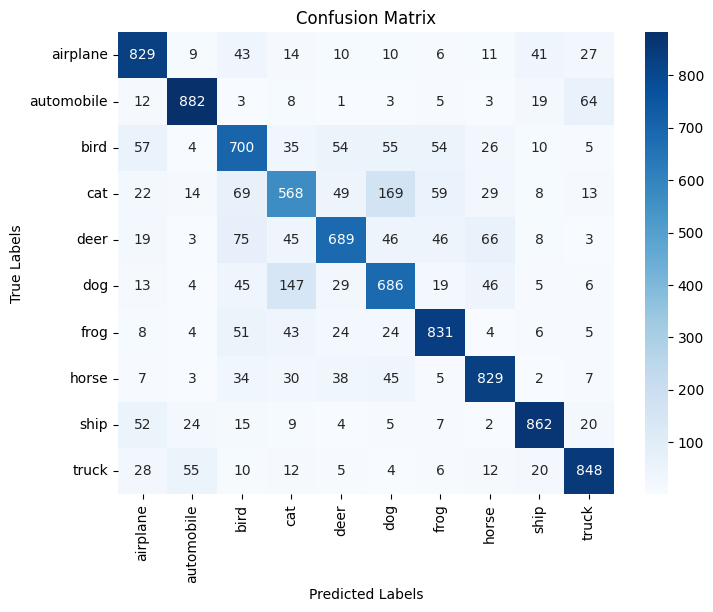


Classification Report:
              precision    recall  f1-score   support

    airplane       0.79      0.83      0.81      1000
  automobile       0.88      0.88      0.88      1000
        bird       0.67      0.70      0.68      1000
         cat       0.62      0.57      0.59      1000
        deer       0.76      0.69      0.72      1000
         dog       0.66      0.69      0.67      1000
        frog       0.80      0.83      0.82      1000
       horse       0.81      0.83      0.82      1000
        ship       0.88      0.86      0.87      1000
       truck       0.85      0.85      0.85      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



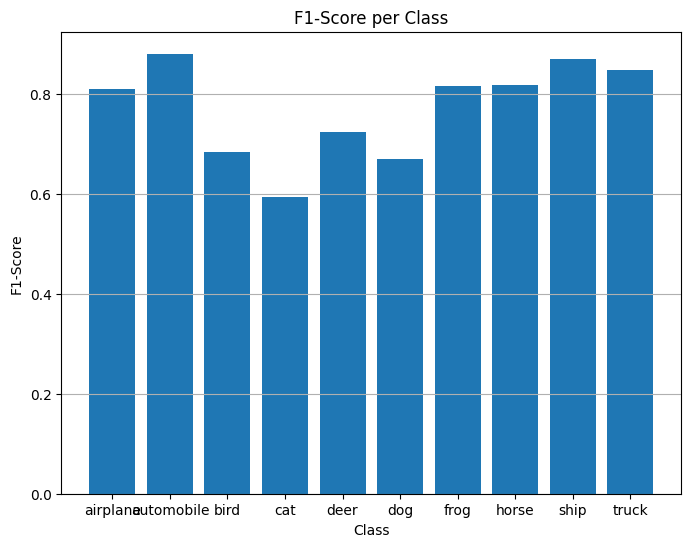

In [ ]:
visualize_model_char(dpout, x_val=test_scaled, y_val=test_target)

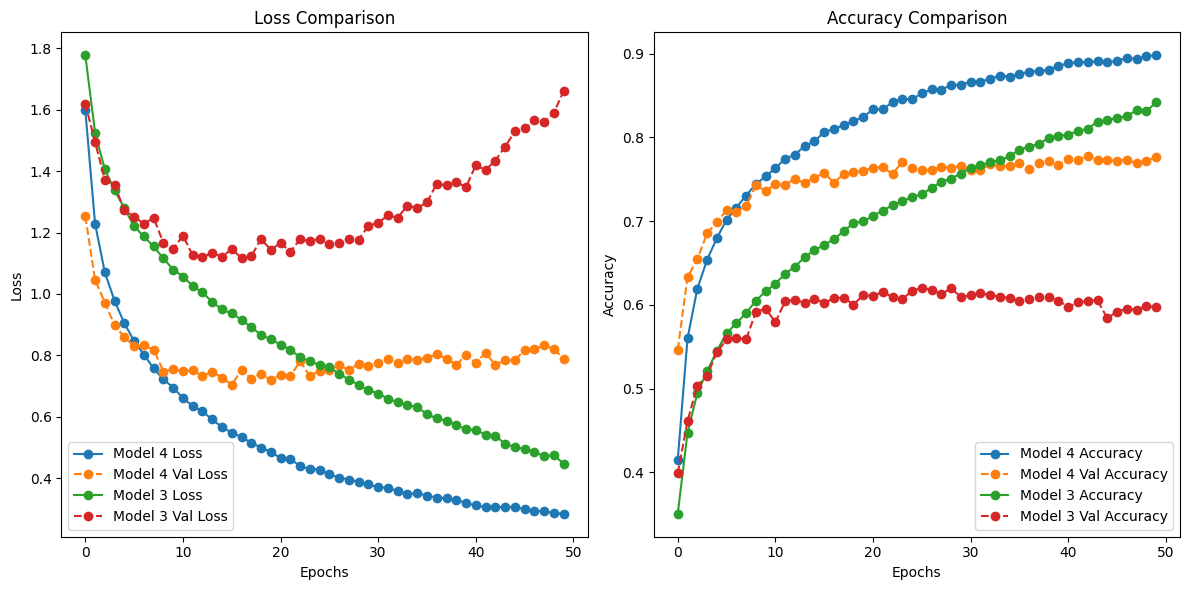

In [ ]:
# 손실 비교
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(dpout_hist.history['loss'], label='Model 4 Loss', marker='o')
plt.plot(dpout_hist.history['val_loss'], label='Model 4 Val Loss', marker='o', linestyle='--')
plt.plot(cnn_hist.history['loss'], label='Model 3 Loss', marker='o')
plt.plot(cnn_hist.history['val_loss'], label='Model 3 Val Loss', marker='o', linestyle='--')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 비교
plt.subplot(1, 2, 2)
plt.plot(dpout_hist.history['accuracy'], label='Model 4 Accuracy', marker='o')
plt.plot(dpout_hist.history['val_accuracy'], label='Model 4 Val Accuracy', marker='o', linestyle='--')
plt.plot(cnn_hist.history['accuracy'], label='Model 3 Accuracy', marker='o')
plt.plot(cnn_hist.history['val_accuracy'], label='Model 3 Val Accuracy', marker='o', linestyle='--')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### 데이터 증강

과대적합은 일반적으로 훈련 예제가 부족할 때 발생한다. 데이터 증강은 증강한 다음 믿을 수 있는 이미지를 생성하는 임의 변환을 사용하는 방법으로 기존 예제에서 추가 훈련 데이터를 생성하는 접근법을 취한다. 그러면 모델이 데이터의 더 많은 측면을 파악하게 되므로 일반화가 더 쉬워진다.\
\
Keras 전처리 레이어 `keras.layers.RandomFlip`, `keras.layers.RandomRotation`, `keras.layers.RandomZoom`을 사용해 데이터 증강을 구현하고, 다른 레이어처럼 이를 모델 내부에 포함해보자.

In [ ]:
from keras.layers import RandomFlip, RandomRotation, RandomZoom

data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.025),
    RandomZoom(0.025)
], name='data_augmentation')

In [ ]:
# 원본 데이터와 증강 데이터 병합
def augment_and_combine_data(images, labels, augment_layer, augment_ratio=0.5):
    # 증강 데이터 생성
    num_augment = int(len(images) * augment_ratio)
    augmented_images = augment_layer(images[:num_augment], training=True)
    augmented_labels = labels[:num_augment]

    # 원본 데이터와 증강 데이터 합치기
    combined_images = np.concatenate([images, augmented_images.numpy()], axis=0)
    combined_labels = np.concatenate([labels, augmented_labels], axis=0)

    return combined_images, combined_labels

# 증강 데이터와 원본 데이터 병합
train_combined, target_combined = augment_and_combine_data(train_scaled, train_target, data_augmentation)

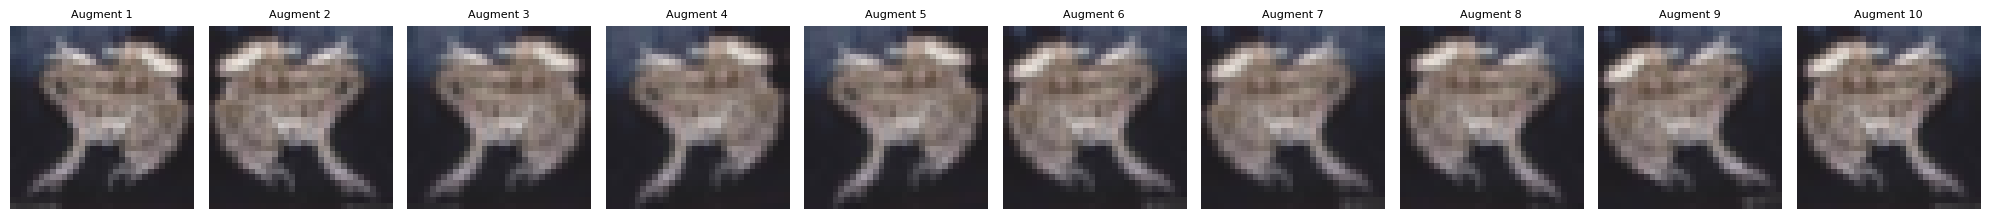

In [ ]:
# 동일한 이미지를 증강하여 여러 번 출력
sample_image = train_scaled[0]  # 첫 번째 이미지 선택
augmented_images = [data_augmentation(np.expand_dims(sample_image, axis=0), training=True)[0] for _ in range(10)]

# 시각화
fig, axes = plt.subplots(1, 10, figsize=(20, 5))
for i, augmented_image in enumerate(augmented_images):
    axes[i].imshow(augmented_image)
    axes[i].axis("off")
    axes[i].set_title(f"Augment {i+1}", fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Conv2D, GlobalAvgPool2D, Dropout, MaxPooling2D
from keras.optimizers import Adam

augment = Sequential(
    name='augment',
    layers=[
        Input(shape=(train_scaled.shape[1:]), name='Input'),
        Conv2D(32, (3, 3), padding='same', activation='relu', name='C1'),
        MaxPooling2D(pool_size=(2, 2), name='S2'),
        Dropout(0.25, name='D3'),
        Conv2D(64, (3, 3), padding='same', activation='relu', name='C4'),
        Conv2D(64, (3, 3), padding='same', activation='relu', name='C5'),
        MaxPooling2D(pool_size=(2, 2), name='S6'),
        Dropout(0.25, name='D7'),
        Flatten(name='Flatten'),
        Dense(512, activation='leaky_relu', name='FC8'),
        Dropout(0.5, name='D9'),
        Dense(10, activation='softmax', name='Output')
    ]
)

augment.summary()

Model: "augment"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ C1 (Conv2D)                          │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ S2 (MaxPooling2D)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ D3 (Dropout)                         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ C4 (Conv2D)                          │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ C5 (Conv2D)                          │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ S6 (MaxPooling2D)                    │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ D7 (Dropout)                         │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC8 (Dense)                          │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ D9 (Dropout)                         │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,159,114 (8.24 MB)

 Trainable params: 2,159,114 (8.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
augment.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
augment_hist = augment.fit(
    train_combined, target_combined,
    batch_size=128, epochs=50,
    validation_data=(val_scaled, val_target),
    verbose=0)

In [ ]:
augment.save(save_dir / 'model5.keras')
save_history_to_json(augment_hist, save_dir, 'model5_history.json')

History successfully saved to /content/Mydrive/MyDrive/object detection datasets/CIFAR10/Model/model5_history.json


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


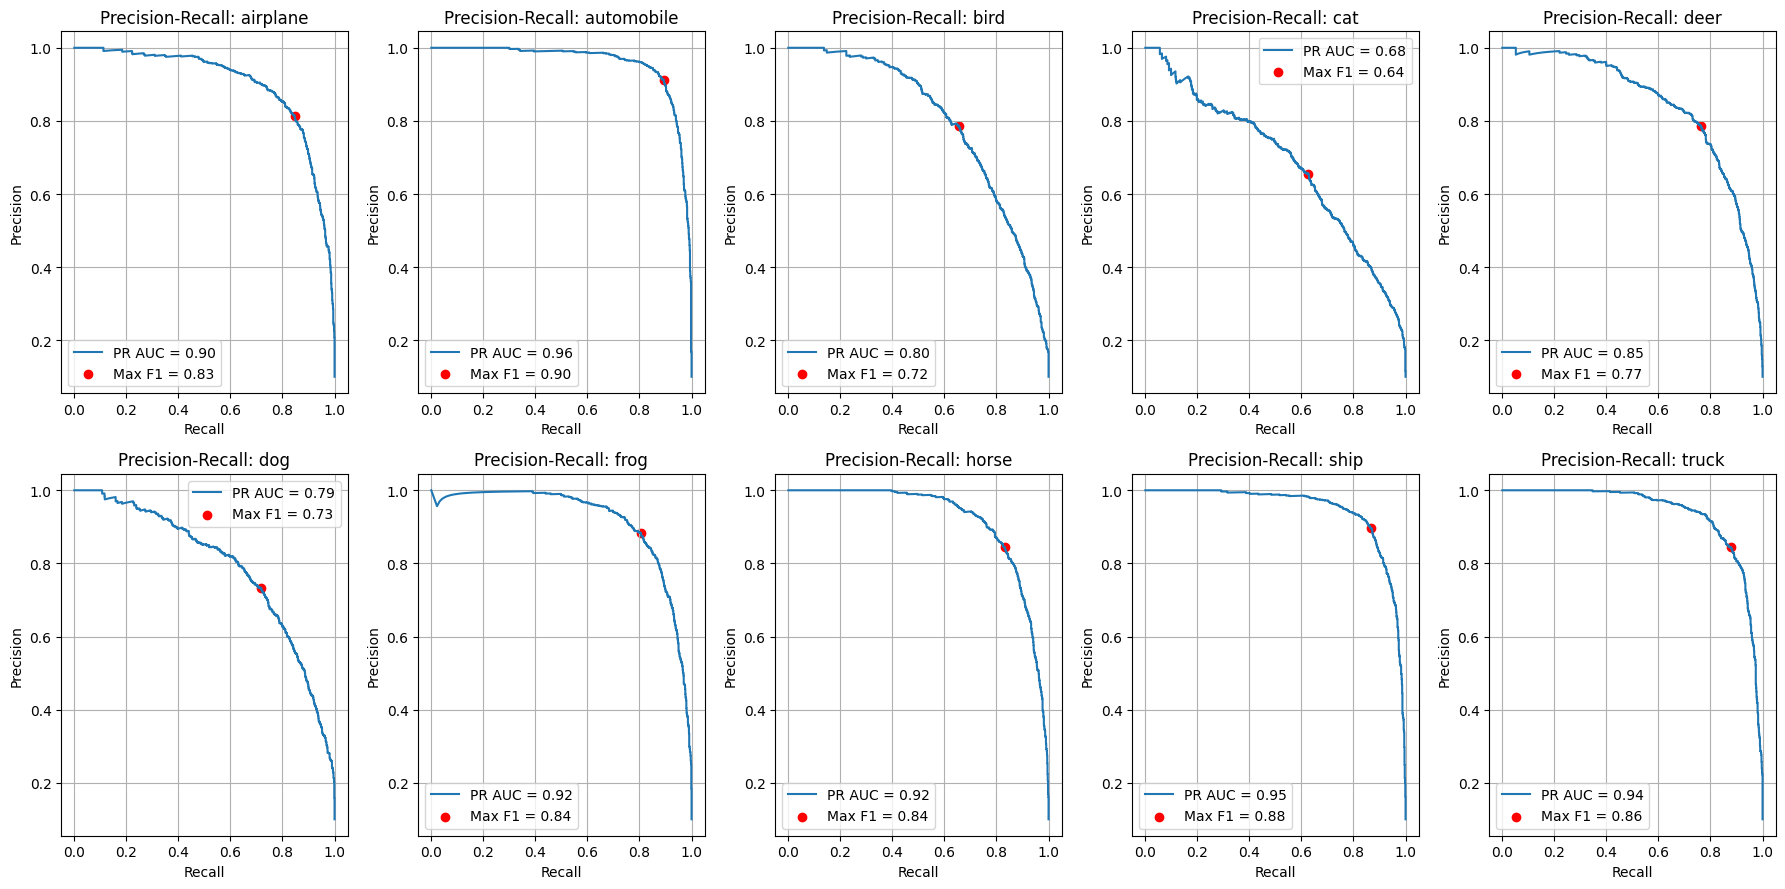

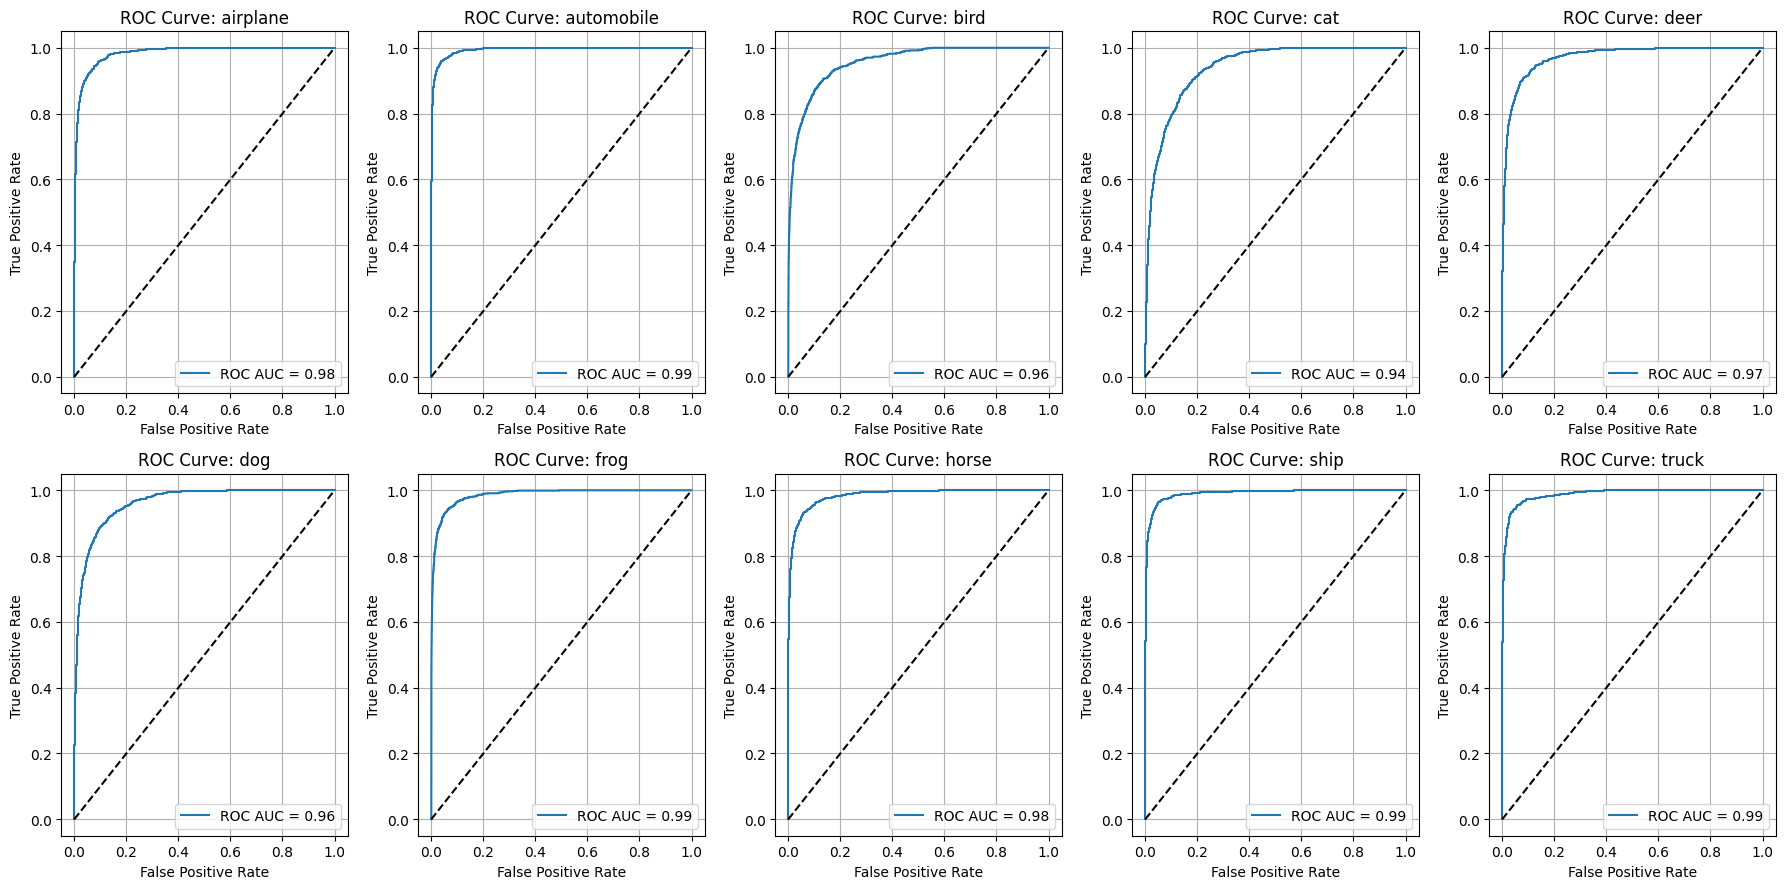

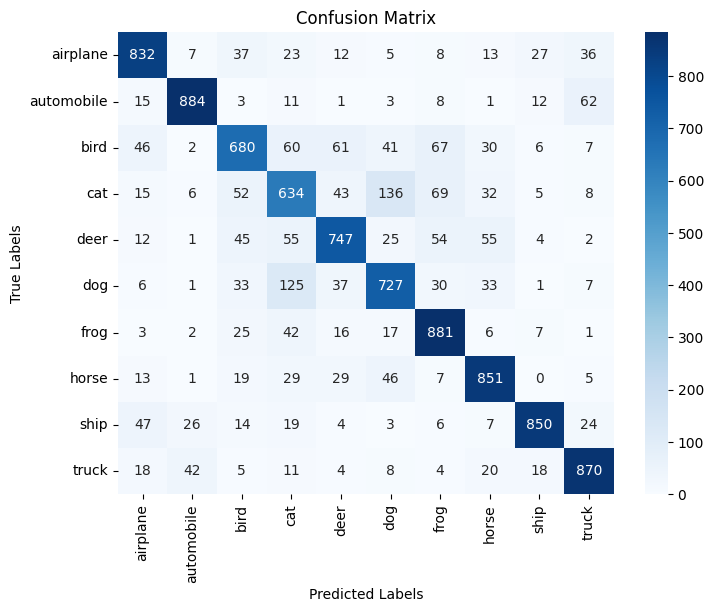


Classification Report:
              precision    recall  f1-score   support

    airplane       0.83      0.83      0.83      1000
  automobile       0.91      0.88      0.90      1000
        bird       0.74      0.68      0.71      1000
         cat       0.63      0.63      0.63      1000
        deer       0.78      0.75      0.76      1000
         dog       0.72      0.73      0.72      1000
        frog       0.78      0.88      0.83      1000
       horse       0.81      0.85      0.83      1000
        ship       0.91      0.85      0.88      1000
       truck       0.85      0.87      0.86      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



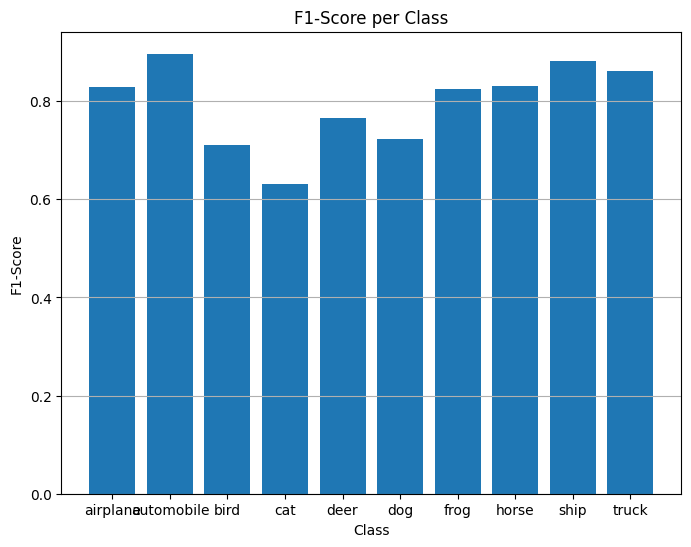

In [ ]:
visualize_model_char(augment, x_val=test_scaled, y_val=test_target)

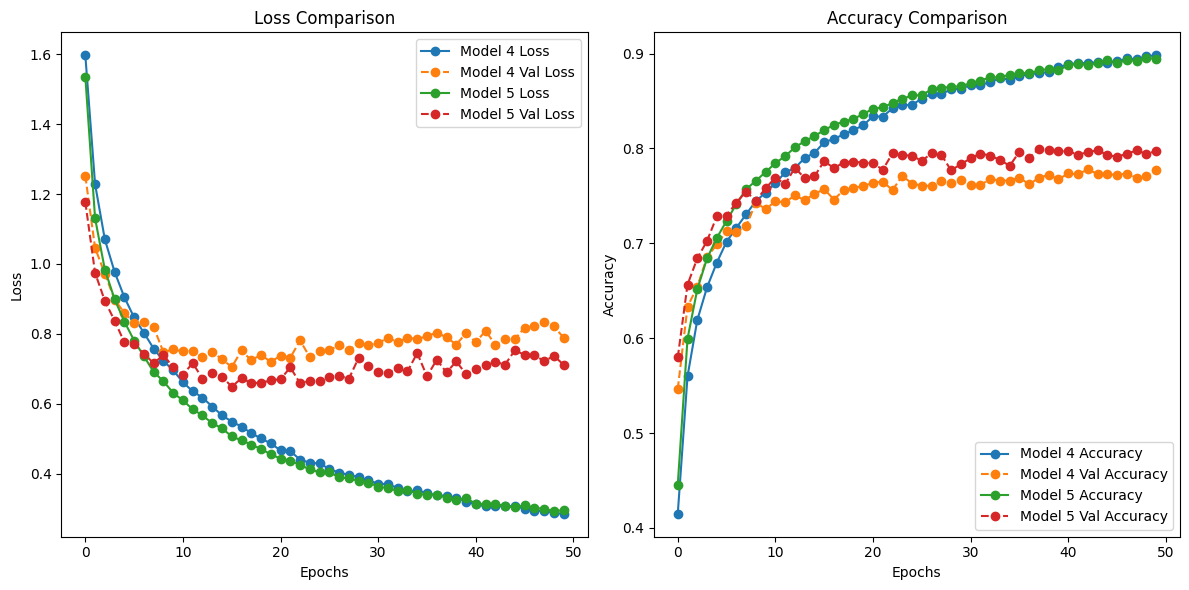

In [ ]:
# 손실 비교
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(dpout_hist.history['loss'], label='Model 4 Loss', marker='o')
plt.plot(dpout_hist.history['val_loss'], label='Model 4 Val Loss', marker='o', linestyle='--')
plt.plot(augment_hist.history['loss'], label='Model 5 Loss', marker='o')
plt.plot(augment_hist.history['val_loss'], label='Model 5 Val Loss', marker='o', linestyle='--')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 비교
plt.subplot(1, 2, 2)
plt.plot(dpout_hist.history['accuracy'], label='Model 4 Accuracy', marker='o')
plt.plot(dpout_hist.history['val_accuracy'], label='Model 4 Val Accuracy', marker='o', linestyle='--')
plt.plot(augment_hist.history['accuracy'], label='Model 5 Accuracy', marker='o')
plt.plot(augment_hist.history['val_accuracy'], label='Model 5 Val Accuracy', marker='o', linestyle='--')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### L2 규제

In [ ]:
from keras.regularizers import l2

add_l2 = Sequential(
    name='add_l2',
    layers=[
        Input(shape=(train_scaled.shape[1:]), name='Input'),
        Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0001), name='C1'),
        MaxPooling2D(pool_size=(2, 2), name='S2'),
        Dropout(0.25, name='D3'),
        Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0001), name='C4'),
        Conv2D(64, (3, 3), padding='same', activation='relu', name='C5'),
        MaxPooling2D(pool_size=(2, 2), name='S6'),
        Dropout(0.25, name='D7'),
        Flatten(name='Flatten'),
        Dense(512, activation='leaky_relu', kernel_regularizer=l2(0.0001), name='FC8'),
        Dropout(0.5, name='D9'),
        Dense(10, activation='softmax', name='Output')
    ]
)

add_l2.summary()

Model: "add_l2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ C1 (Conv2D)                          │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ S2 (MaxPooling2D)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ D3 (Dropout)                         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ C4 (Conv2D)                          │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ C5 (Conv2D)                          │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ S6 (MaxPooling2D)                    │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ D7 (Dropout)                         │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC8 (Dense)                          │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ D9 (Dropout)                         │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,159,114 (8.24 MB)

 Trainable params: 2,159,114 (8.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
add_l2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
add_l2_hist = add_l2.fit(
    train_combined, target_combined,
    batch_size=128, epochs=50,
    validation_data=(val_scaled, val_target),
    verbose=0)

In [ ]:
add_l2.save(save_dir / 'model6.keras')
save_history_to_json(add_l2_hist, save_dir, 'model6_history.json')

History successfully saved to /content/Mydrive/MyDrive/object detection datasets/CIFAR10/Model/model6_history.json


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


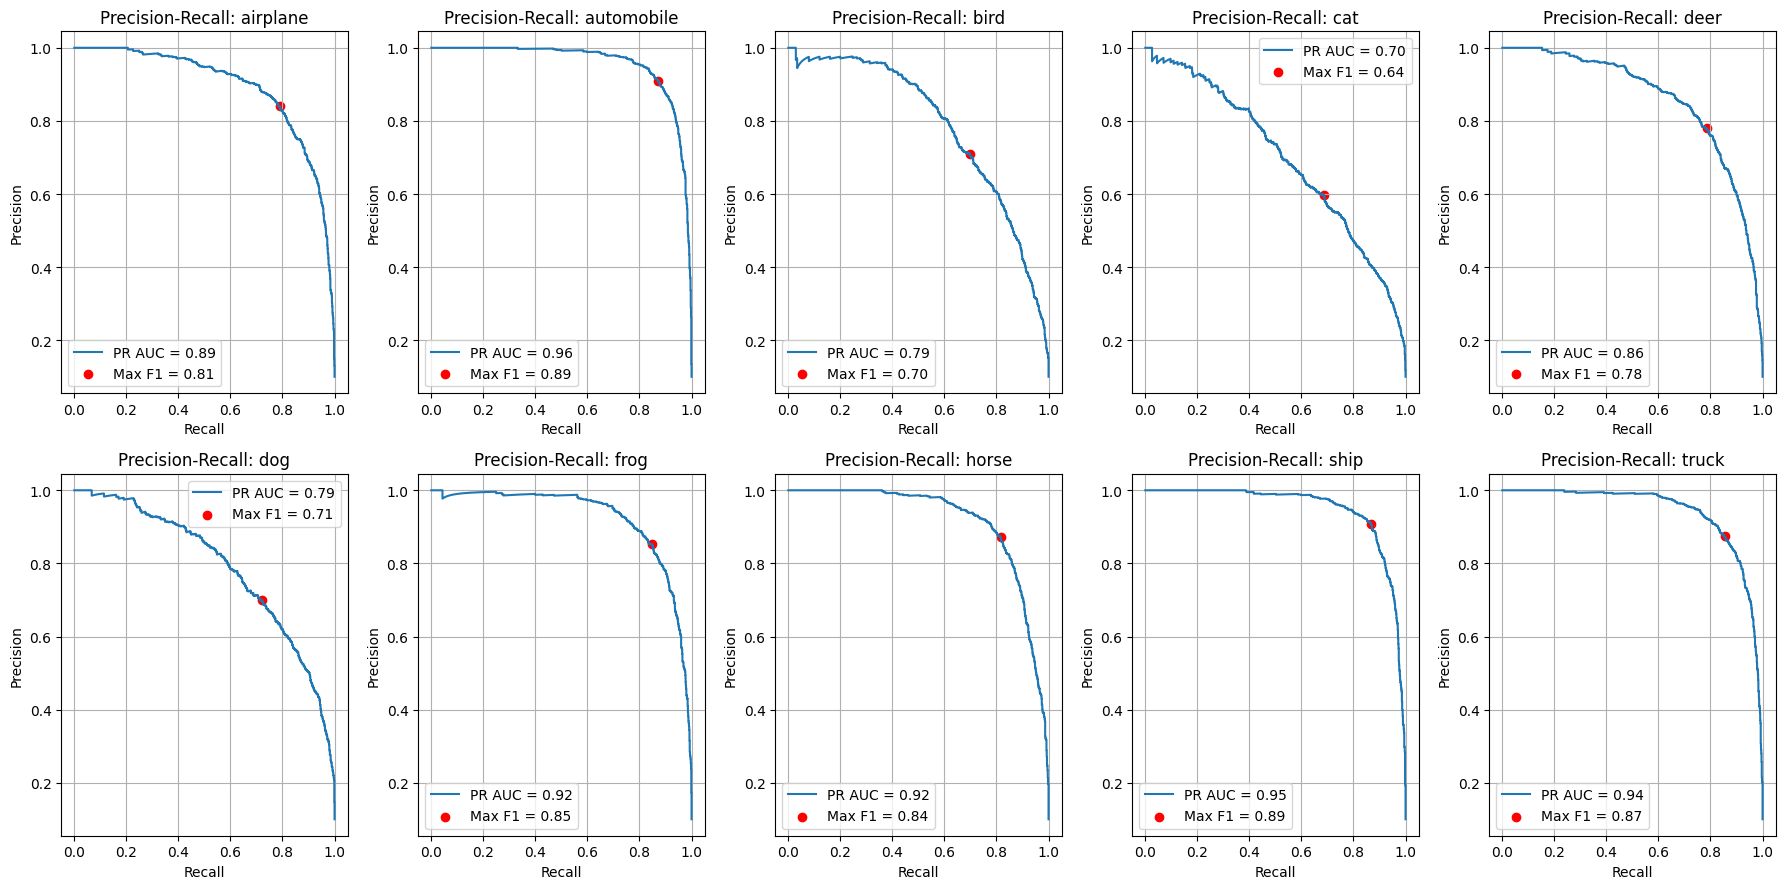

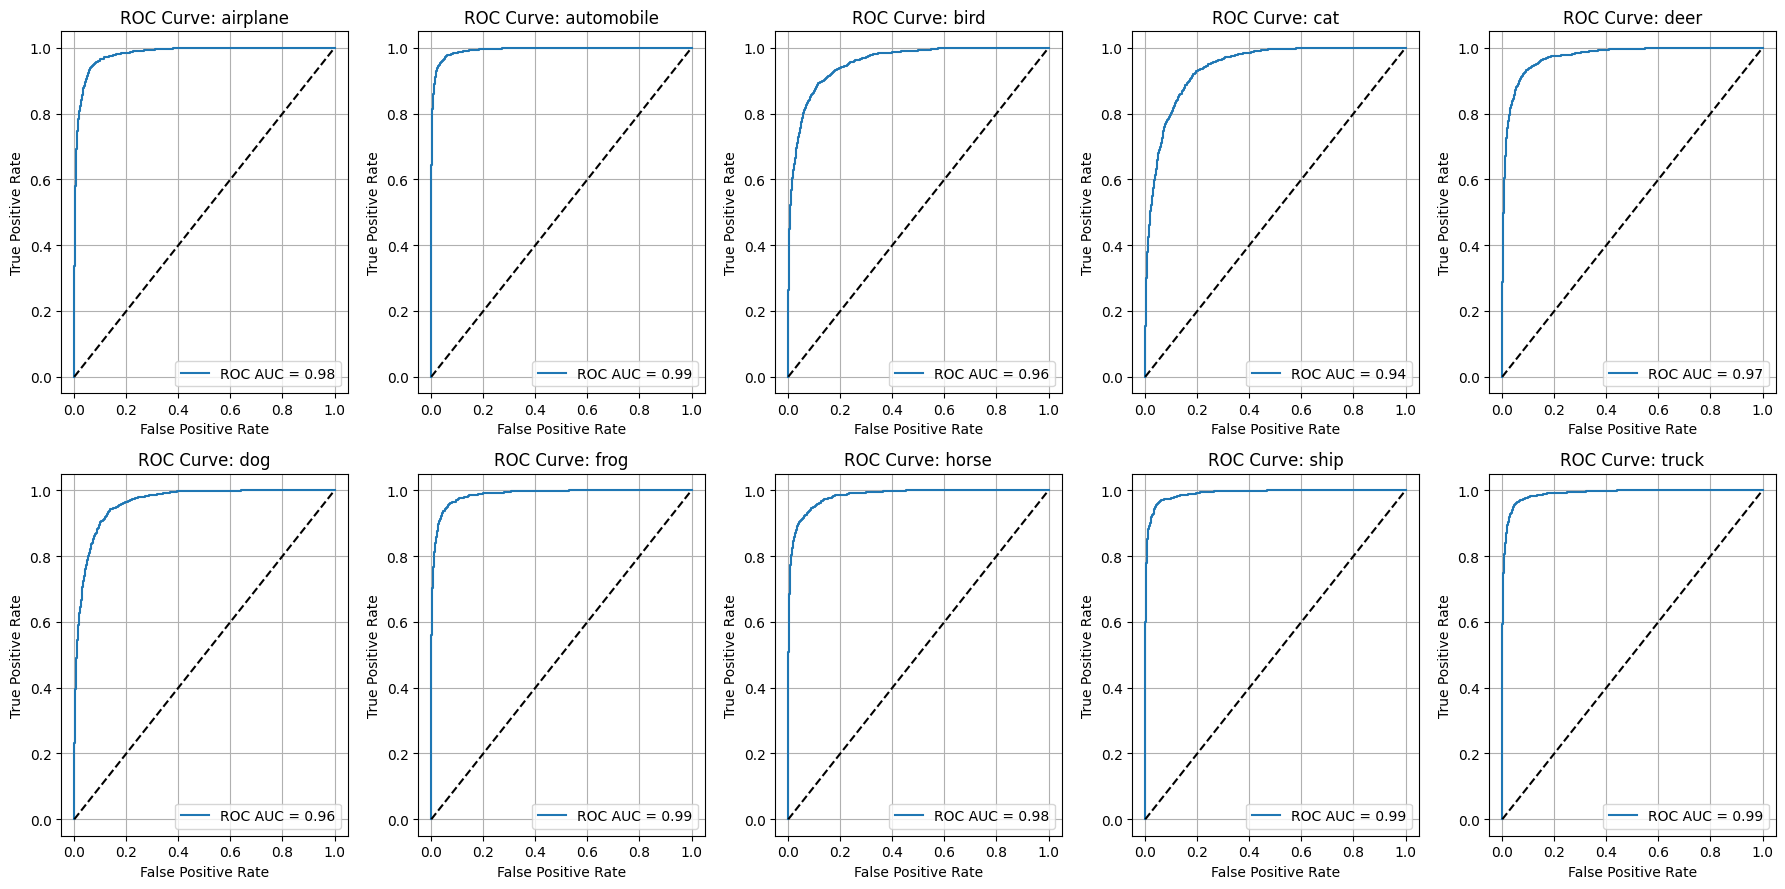

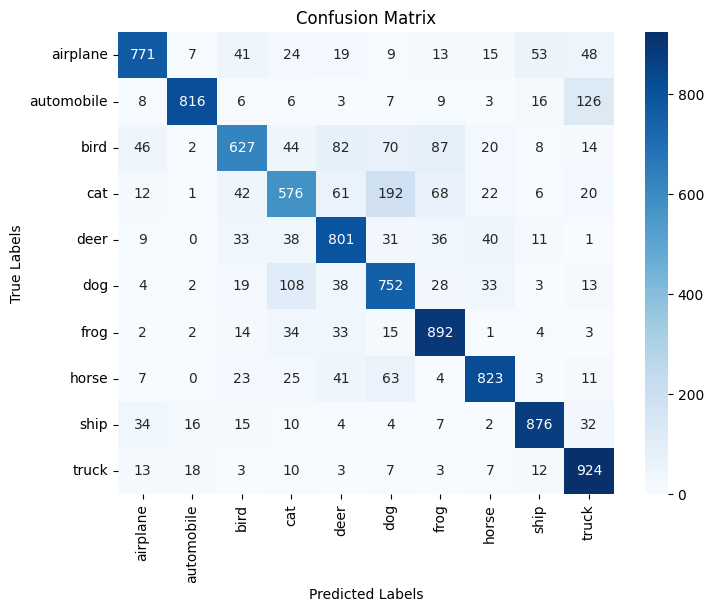


Classification Report:
              precision    recall  f1-score   support

    airplane       0.85      0.77      0.81      1000
  automobile       0.94      0.82      0.88      1000
        bird       0.76      0.63      0.69      1000
         cat       0.66      0.58      0.61      1000
        deer       0.74      0.80      0.77      1000
         dog       0.65      0.75      0.70      1000
        frog       0.78      0.89      0.83      1000
       horse       0.85      0.82      0.84      1000
        ship       0.88      0.88      0.88      1000
       truck       0.78      0.92      0.84      1000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.78     10000
weighted avg       0.79      0.79      0.78     10000



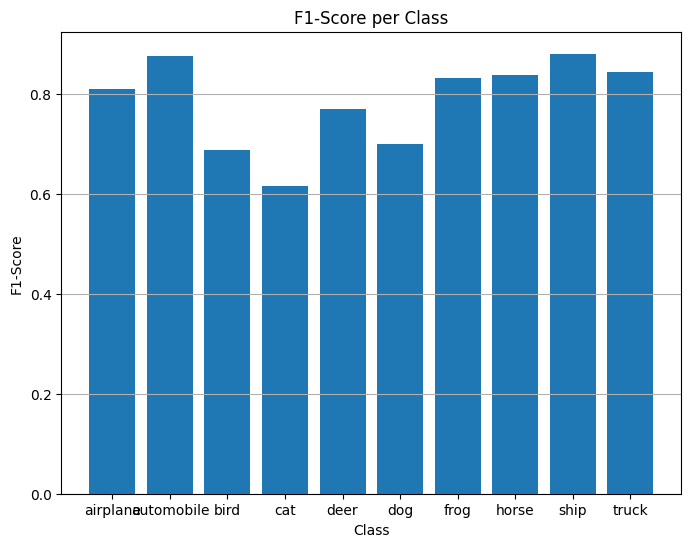

In [ ]:
visualize_model_char(add_l2, x_val=test_scaled, y_val=test_target)

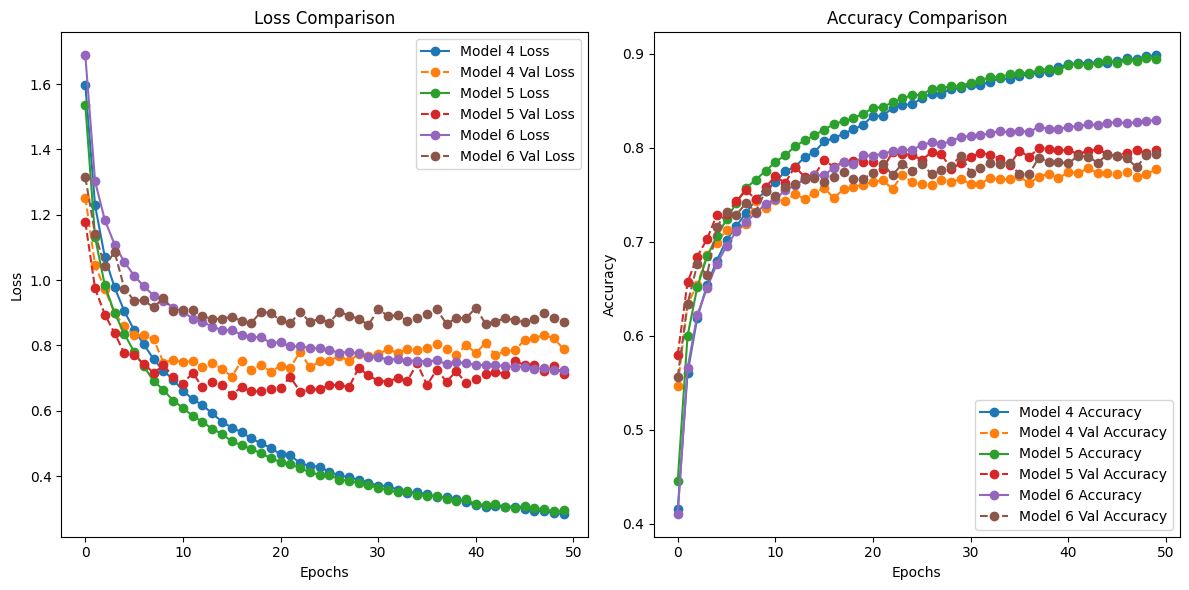

In [ ]:
# 손실 비교
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(dpout_hist.history['loss'], label='Model 4 Loss', marker='o')
plt.plot(dpout_hist.history['val_loss'], label='Model 4 Val Loss', marker='o', linestyle='--')
plt.plot(augment_hist.history['loss'], label='Model 5 Loss', marker='o')
plt.plot(augment_hist.history['val_loss'], label='Model 5 Val Loss', marker='o', linestyle='--')
plt.plot(add_l2_hist.history['loss'], label='Model 6 Loss', marker='o')
plt.plot(add_l2_hist.history['val_loss'], label='Model 6 Val Loss', marker='o', linestyle='--')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 비교
plt.subplot(1, 2, 2)
plt.plot(dpout_hist.history['accuracy'], label='Model 4 Accuracy', marker='o')
plt.plot(dpout_hist.history['val_accuracy'], label='Model 4 Val Accuracy', marker='o', linestyle='--')
plt.plot(augment_hist.history['accuracy'], label='Model 5 Accuracy', marker='o')
plt.plot(augment_hist.history['val_accuracy'], label='Model 5 Val Accuracy', marker='o', linestyle='--')
plt.plot(add_l2_hist.history['accuracy'], label='Model 6 Accuracy', marker='o')
plt.plot(add_l2_hist.history['val_accuracy'], label='Model 6 Val Accuracy', marker='o', linestyle='--')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## 반복을 통한 최적 모델 탐색

드롭아웃과 l2규제를 몇 번 바꿔가며 모델을 만들어보자.

In [ ]:
# 규제 강도 리스트
l2_values = [0.0001, 0.001]
dropout_values = [0.125, 0.25, 0.5]

# 학습 결과 저장
histories = {}

# 루프를 통해 규제 강도를 변경하며 모델 학습
for l2_value in l2_values:
    for dropout_value in dropout_values:
        # 모델 생성
        model = Sequential(
                name=f'cnn_l2_{l2_value}_drp_{dropout_value}',
                layers=[
                    Input(shape=(train_scaled.shape[1:]), name='Input'),
                    Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_value), name='C1'),
                    MaxPooling2D(pool_size=(2, 2), name='S2'),
                    Dropout(dropout_value, name='D3'),
                    Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_value), name='C4'),
                    Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_value), name='C5'),
                    MaxPooling2D(pool_size=(2, 2), name='S6'),
                    Dropout(dropout_value, name='D7'),
                    Flatten(name='Flatten'),
                    Dense(512, activation='relu', kernel_regularizer=l2(l2_value), name='FC8'),
                    Dropout(dropout_value, name='D9'),
                    Dense(10, activation='softmax', name='Output')
                ]
            )


    # 모델 컴파일
        optimizer = Adam(learning_rate=0.0005)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # 모델 학습
        history = model.fit(
            train_combined, target_combined,
            validation_data=(val_scaled, val_target),
            epochs=50,  # 학습 에포크 수
            batch_size=128,
            verbose=0
        )

        # 학습 기록 저장
        histories[f'l2_{l2_value}_drp_{dropout_value}'] = history
        print(f"Finished: l2={l2_value}, dropout={dropout_value}")

Finished: l2=0.0001, dropout=0.125
Finished: l2=0.0001, dropout=0.25
Finished: l2=0.0001, dropout=0.5
Finished: l2=0.001, dropout=0.125
Finished: l2=0.001, dropout=0.25
Finished: l2=0.001, dropout=0.5


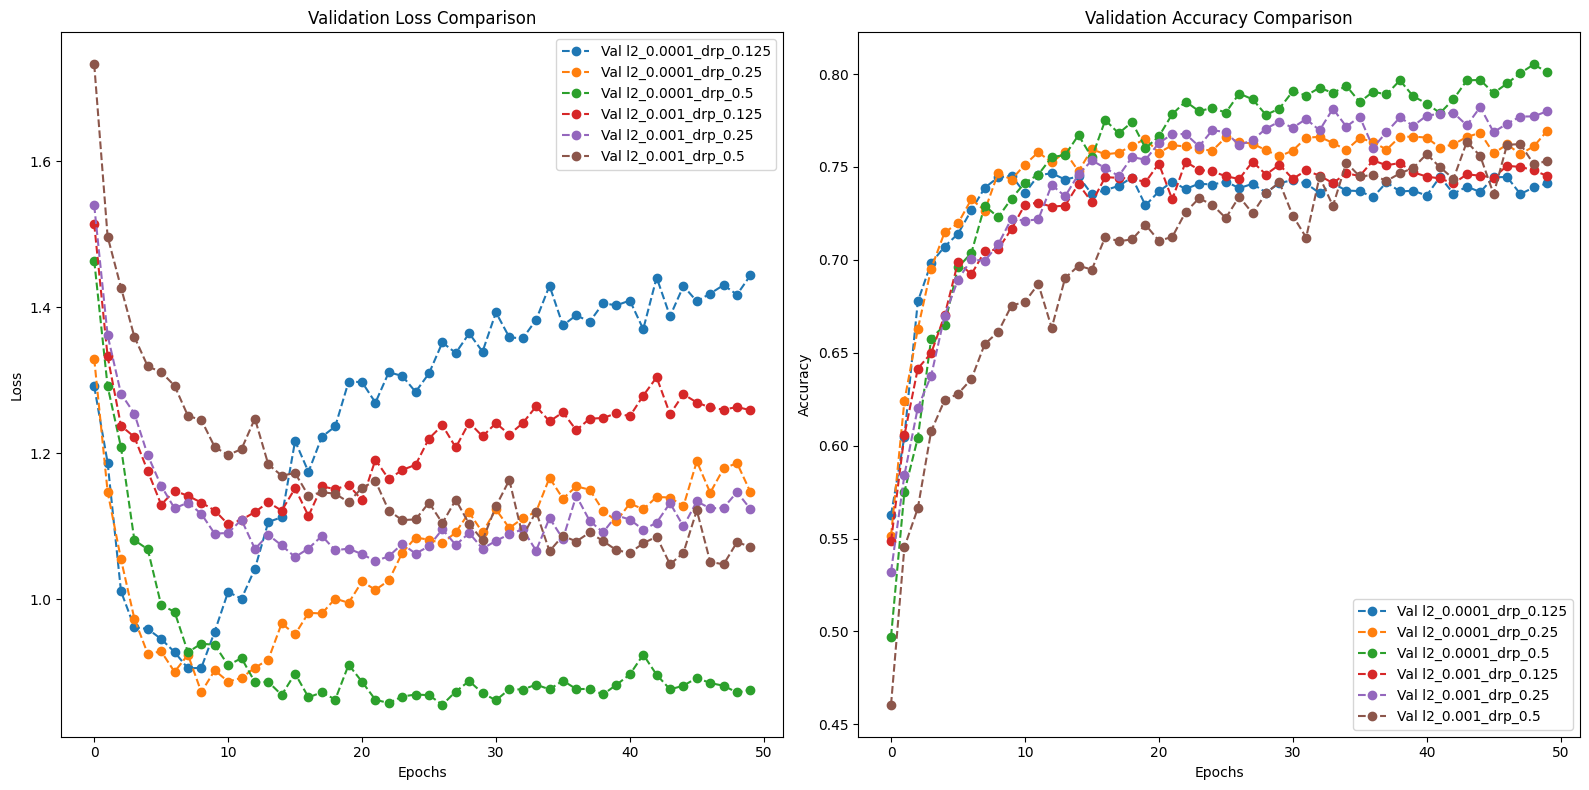

In [ ]:
plt.figure(figsize=(16, 8))

# 손실 비교
plt.subplot(1, 2, 1)
for key, history in histories.items():
    # key는 'l2_{l2_value}_drp_{dropout1}' 형태
    plt.plot(history.history['val_loss'], label=f'Val {key}', marker='o', linestyle='--')

plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 비교
plt.subplot(1, 2, 2)
for key, history in histories.items():
    # key는 'l2_{l2_value}_drp_{dropout1}' 형태
    plt.plot(history.history['val_accuracy'], label=f'Val {key}', marker='o', linestyle='--')

plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
for key, history in histories.items():
    print(f"{key}: Best val_accuracy = {max(history.history['val_accuracy']):.4f}")


l2_0.0001_drp_0.125: Best val_accuracy = 0.7466
l2_0.0001_drp_0.25: Best val_accuracy = 0.7694
l2_0.0001_drp_0.5: Best val_accuracy = 0.8052
l2_0.001_drp_0.125: Best val_accuracy = 0.7535
l2_0.001_drp_0.25: Best val_accuracy = 0.7822
l2_0.001_drp_0.5: Best val_accuracy = 0.7635


## 배치 정규화를 더한 최종모델


최종적으로 모델을 선택할 것이다. 위 지표들을 종합해 보건데, 원본과 증강 데이터들을 합하고, 드롭아웃을 0.5, l2를 0.0001로 만드는 모델이 가장 좋은 모델로 나온다. 이 모델에 배치 정규화 레이어를 추가해 최종 모델을 설계해보자.

In [ ]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/Mydrive')

save_dir = Path('/content/Mydrive/MyDrive/object detection datasets/CIFAR10/Model')

Mounted at /content/Mydrive


In [ ]:
import os
import json

def save_history_to_json(history, directory, filename="history.json"):
    """
    모델 학습 히스토리를 JSON 파일로 저장하는 함수.

    Parameters:
    - history (keras.callbacks.History): model.fit()으로 반환된 학습 히스토리 객체.
    - directory (str): 히스토리를 저장할 디렉토리 경로.
    - filename (str): 저장할 파일 이름. 기본값은 'history.json'.

    Returns:
    - None
    """
    try:
        # 디렉토리가 존재하지 않으면 생성
        if not os.path.exists(directory):
            os.makedirs(directory)

        # 저장 경로 설정
        file_path = os.path.join(directory, filename)

        # 히스토리 객체에서 딕셔너리 추출
        history_dict = history.history

        # JSON 파일로 저장
        with open(file_path, 'w') as json_file:
            json.dump(history_dict, json_file)

        print(f"History successfully saved to {file_path}")
    except Exception as e:
        print(f"An error occurred while saving history: {e}")


In [ ]:
def plot_accuracy_and_loss(history):
    """
    모델 학습 과정에서 정확도와 손실을 시각화하는 함수.

    Parameters:
        history: keras.callbacks.History - 모델 학습 후 반환된 히스토리 객체.

    Returns:
        None
    """
    import matplotlib.pyplot as plt

    # 에포크 수
    epochs = range(1, len(history.history['accuracy']) + 1)

    # 그래프 크기 설정
    plt.figure(figsize=(14, 6))

    # 1. 정확도 시각화
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', marker='o', linestyle='--')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)

    # 2. 손실 시각화
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss', marker='o')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', marker='o', linestyle='--')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)

    # 레이아웃 정리 및 출력
    plt.tight_layout()
    plt.show()


In [ ]:
def visualize_model_char(model, x_val, y_val, class_names=None):
    """
    모델의 성능을 평가하고 혼동 행렬과 다양한 지표를 시각화합니다.

    Parameters:
        model: keras.Model - 평가할 Keras 모델
        x_val: np.array - 검증 데이터 (입력)
        y_val: np.array 또는 list - 검증 데이터 (레이블)
        class_names: list - 클래스 이름 (옵션, 제공하지 않을 경우 숫자 인덱스로 표시)

    Returns:
        None
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import (precision_recall_curve, roc_curve,
                                 auc, classification_report,
                                 confusion_matrix, f1_score)
    from sklearn.preprocessing import label_binarize
    import numpy as np

    # y_val을 numpy 배열로 변환
    y_val = np.array(y_val)

    # 클래스 이름 설정
    num_classes = len(np.unique(y_val))
    if class_names is None:
        class_names = ["airplane", "automobile", "bird",
                       "cat","deer", "dog", "frog",
                       "horse","ship", "truck"]

    # 예측 수행
    predictions = model.predict(x_val)
    predicted_classes = predictions.argmax(axis=1)

    # 레이블 이진화 (ROC-AUC 및 다중 클래스 대응)
    y_val_binarized = label_binarize(y_val, classes=range(num_classes))

    # 정밀도-재현율 곡선 및 ROC 곡선 준비
    precision = {}
    recall = {}
    fpr = {}
    tpr = {}
    pr_auc = {}
    roc_auc = {}

    for i in range(num_classes):
        precision[i], recall[i], thresholds = precision_recall_curve(y_val_binarized[:, i], predictions[:, i])
        fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], predictions[:, i])
        pr_auc[i] = auc(recall[i], precision[i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 1. Precision-Recall Curve 서브플롯
    fig, axes = plt.subplots(2, 5, figsize=(18, 9))
    axes = axes.ravel()

    for i in range(num_classes):
        # F1-스코어 계산
        f1_scores = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i] + 1e-10)
        max_f1_index = np.argmax(f1_scores)
        max_f1 = f1_scores[max_f1_index]

        # PR 커브 그리기
        axes[i].plot(recall[i], precision[i], label=f'PR AUC = {pr_auc[i]:.2f}')
        axes[i].scatter(recall[i][max_f1_index], precision[i][max_f1_index], color='red', label=f'Max F1 = {max_f1:.2f}')
        axes[i].set_title(f'Precision-Recall: {class_names[i]}')
        axes[i].set_xlabel('Recall')
        axes[i].set_ylabel('Precision')
        axes[i].legend()
        axes[i].grid()

    plt.tight_layout()
    plt.show()

    # 2. ROC Curve 서브플롯
    fig, axes = plt.subplots(2, 5, figsize=(18, 9))
    axes = axes.ravel()

    for i in range(num_classes):
        axes[i].plot(fpr[i], tpr[i], label=f'ROC AUC = {roc_auc[i]:.2f}')
        axes[i].plot([0, 1], [0, 1], 'k--')  # Random Guess
        axes[i].set_title(f'ROC Curve: {class_names[i]}')
        axes[i].set_xlabel('False Positive Rate')
        axes[i].set_ylabel('True Positive Rate')
        axes[i].legend()
        axes[i].grid()

    plt.tight_layout()
    plt.show()

    # 3. 혼동 행렬 시각화
    conf_matrix = confusion_matrix(y_val, predicted_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # 4. Classification Report
    print("\nClassification Report:")
    print(classification_report(y_val, predicted_classes, target_names=class_names))

    # 5. F1-Score 막대그래프
    f1_per_class = f1_score(y_val, predicted_classes, average=None)

    plt.figure(figsize=(8, 6))
    plt.bar(range(num_classes), f1_per_class, tick_label=class_names)
    plt.title('F1-Score per Class')
    plt.xlabel('Class')
    plt.ylabel('F1-Score')
    plt.grid(axis='y')
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import (Dense, Conv2D, Flatten,
                          MaxPooling2D, Dropout, Input,
                          BatchNormalization, RandomFlip,
                          RandomRotation, RandomZoom)
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [ ]:
# 데이터 불러오기
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 데이터 확인
print(f"x_train shape: {x_train.shape}" )
print(f"y_train shape: {y_train.shape}" )
print(f"x_test shape: {x_test.shape}" )
print(f"y_test shape: {y_test.shape}" )

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [ ]:
train_scaled = x_train / 255.0
test_scaled = x_test / 255.0
train_target = tf.keras.utils.to_categorical(y_train)
test_target = tf.keras.utils.to_categorical(y_test)


train_target = np.argmax(train_target, axis=1)
test_target =np.argmax(test_target, axis=1)

print(f'train_scaled shape: {train_scaled.shape}')
print(f'test_scaled shape: {test_scaled.shape}')
print()
print(f'train_target shape: {train_target.shape}')
print(f'test_target shape: {test_target.shape}')

train_scaled shape: (50000, 32, 32, 3)
test_scaled shape: (10000, 32, 32, 3)

train_target shape: (50000,)
test_target shape: (10000,)


In [ ]:
data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.025),
    RandomZoom(0.025)
], name='data_augmentation')

In [ ]:
# 원본 데이터와 증강 데이터 병합
def augment_and_combine_data(images, labels, augment_layer, augment_ratio=0.5):
    # 증강 데이터 생성
    num_augment = int(len(images) * augment_ratio)
    augmented_images = augment_layer(images[:num_augment], training=True)
    augmented_labels = labels[:num_augment]

    # 원본 데이터와 증강 데이터 합치기
    combined_images = np.concatenate([images, augmented_images.numpy()], axis=0)
    combined_labels = np.concatenate([labels, augmented_labels], axis=0)

    return combined_images, combined_labels

# 증강 데이터와 원본 데이터 병합
train_combined, target_combined = augment_and_combine_data(train_scaled, train_target, data_augmentation)

In [ ]:
final_model = Sequential(
    name='Final',
    layers=[
        Input(shape=(train_combined.shape[1:]), name='Input'),
        Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0001), name='C1'),
        MaxPooling2D(pool_size=(2, 2), name='S2'),
        Dropout(0.5, name='D3'),
        Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0001), name='C4'),
        BatchNormalization(name='BN5'),
        Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0001), name='C6'),
        MaxPooling2D(pool_size=(2, 2), name='S7'),
        Dropout(0.5, name='D8'),
        Flatten(name='Flatten'),
        BatchNormalization(name='BN9'),
        Dense(512, activation='relu', kernel_regularizer=l2(0.0001), name='FC10'),
        Dropout(0.5, name='D11'),
        Dense(10, activation='softmax', name='Output')
    ]
)

In [ ]:
final_model.summary()

Model: "Final"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ C1 (Conv2D)                          │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ S2 (MaxPooling2D)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ D3 (Dropout)                         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ C4 (Conv2D)                          │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BN5 (BatchNormalization)             │ (None, 16, 16, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ C6 (Conv2D)                          │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ S7 (MaxPooling2D)                    │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ D8 (Dropout)                         │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BN9 (BatchNormalization)             │ (None, 4096)                │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC10 (Dense)                         │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ D11 (Dropout)                        │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,510,624 (24.84 MB)

 Trainable params: 2,167,434 (8.27 MB)

 Non-trainable params: 8,320 (32.50 KB)

 Optimizer params: 4,334,870 (16.54 MB)

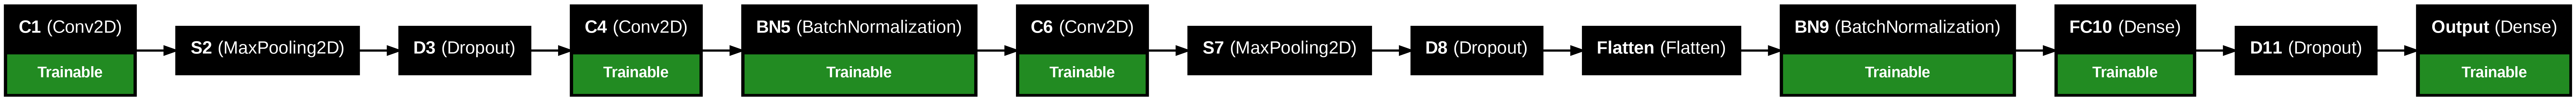

In [ ]:
keras.utils.plot_model(final_model, to_file='final_model.png', show_layer_names=True, dpi=300, show_trainable=True, rankdir='LR')

In [ ]:
optimizer = Adam(learning_rate=0.0005)
final_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# 조기 종료 콜백 정의
early_stopping = EarlyStopping(
    monitor='loss',       # 모니터링할 값 (예: 'val_loss', 'val_accuracy')
    patience=10,              # 개선되지 않아도 기다리는 에포크 수
    restore_best_weights=True # 조기 종료 시 최적의 가중치 복원
)

In [ ]:
history = final_model.fit(
    train_combined, target_combined,
    epochs=100,
    batch_size=128,
    callbacks=[early_stopping],
    validation_data=(test_scaled, test_target),
    verbose=0
)

In [ ]:
final_model.save(save_dir / 'batch_model.keras')
save_history_to_json(history, save_dir, 'batch_model_history.json')

History successfully saved to /content/Mydrive/MyDrive/object detection datasets/CIFAR10/Model/batch_model_history.json


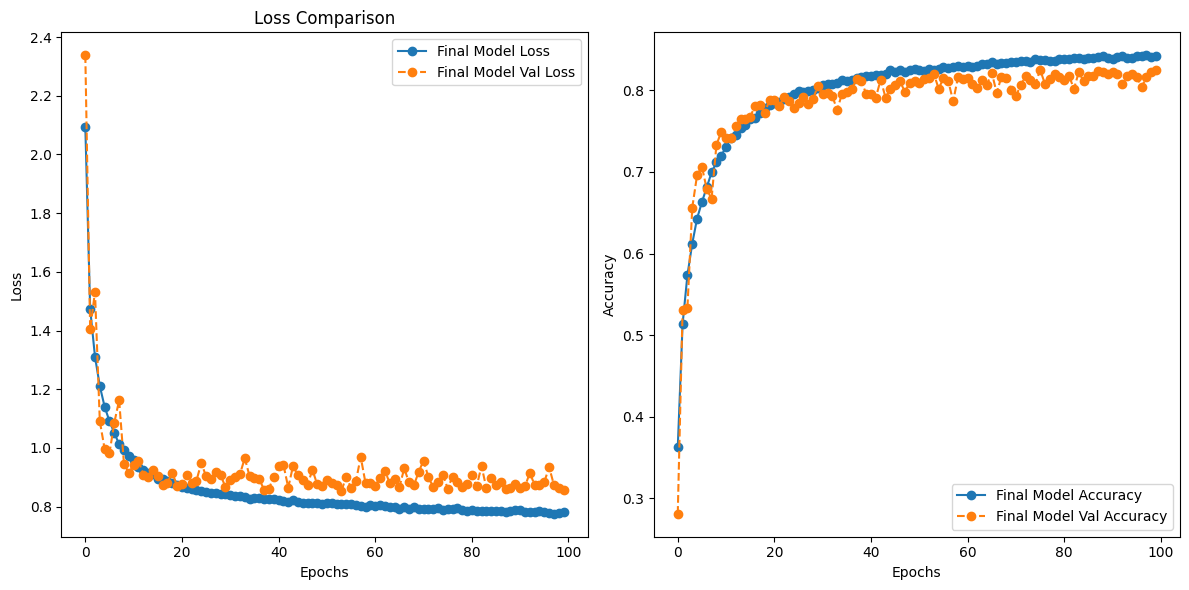

In [ ]:
# 손실 비교
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Final Model Loss', marker='o')
plt.plot(history.history['val_loss'], label='Final Model Val Loss', marker='o', linestyle='--')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 비교
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Final Model Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Final Model Val Accuracy', marker='o', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


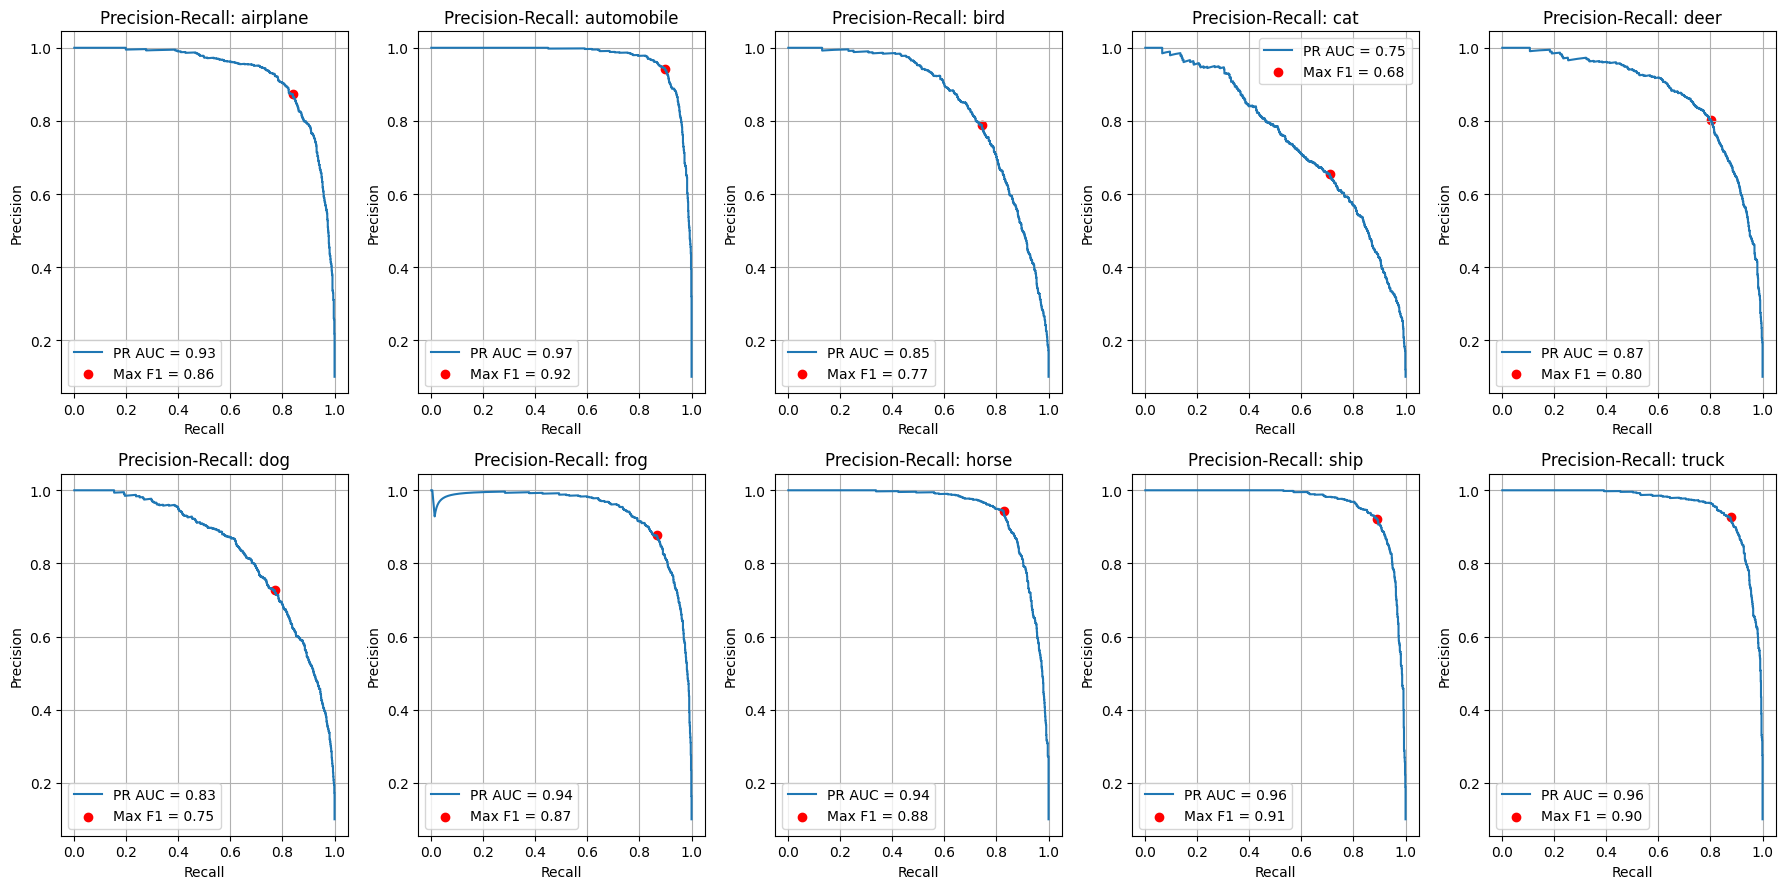

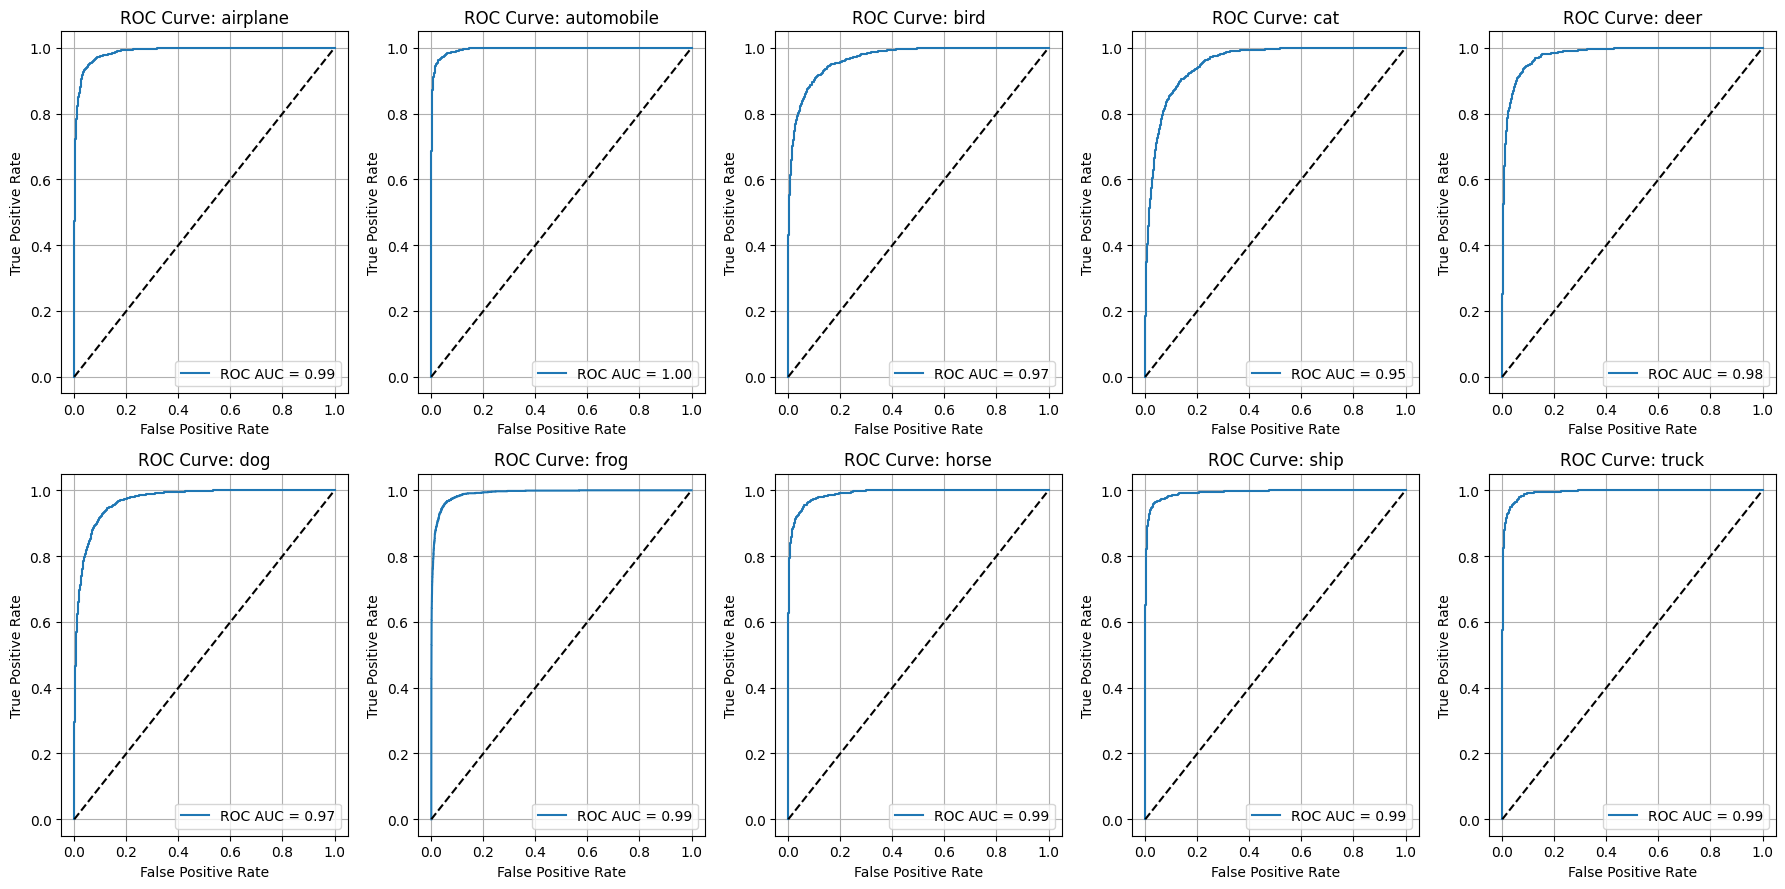

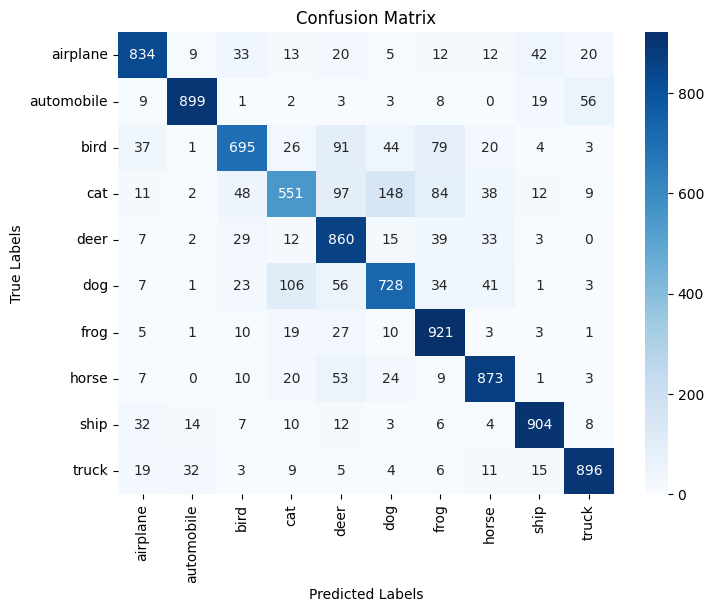


Classification Report:
              precision    recall  f1-score   support

    airplane       0.86      0.83      0.85      1000
  automobile       0.94      0.90      0.92      1000
        bird       0.81      0.69      0.75      1000
         cat       0.72      0.55      0.62      1000
        deer       0.70      0.86      0.77      1000
         dog       0.74      0.73      0.73      1000
        frog       0.77      0.92      0.84      1000
       horse       0.84      0.87      0.86      1000
        ship       0.90      0.90      0.90      1000
       truck       0.90      0.90      0.90      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.81     10000
weighted avg       0.82      0.82      0.81     10000



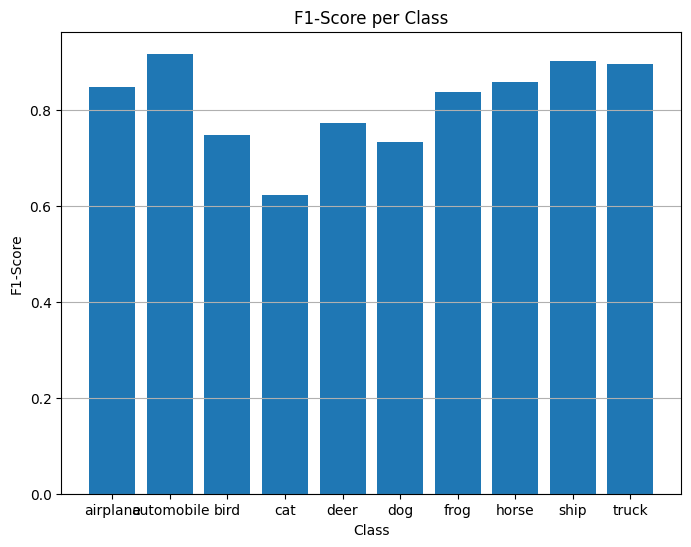

In [ ]:
visualize_model_char(final_model, x_val=test_scaled, y_val=test_target)

In [ ]:
test_loss, test_accuracy = final_model.evaluate(test_scaled, test_target, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8183 - loss: 0.8716


In [ ]:
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss: 0.8731001019477844
Test Accuracy: 0.816100001335144
